In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import f_oneway
import mysinkhorn

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_1342/3970168669.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# ANALISI DATI fMRI- cluster ottenuti da soggetti concatenati
- owner Miriam Zara
- last modified 08/03/2024

Definizione e plot della matrice di costo EUCLIDEA

In [2]:
data = np.loadtxt('cluster_centroids_k_8.csv', delimiter= ',')
centroidi = np.array(data)
n_cluster = centroidi.shape[0]
n_parcels = centroidi.shape[1]
cost_sqeuclidean = np.zeros((n_cluster,n_cluster))
for i in range(n_cluster):
    for j in range(n_cluster):
        cost_sqeuclidean[i,j]=np.linalg.norm(centroidi[i]-centroidi[j])**2
cost_sqeuclidean/=cost_sqeuclidean.max()

Definizione e plot della matrice di costo delle PROBABILITA'  DI TRANSIZIONE

In [3]:
data_conteggi = np.loadtxt('transitions_grouped_8.csv', delimiter=',')
conteggi = np.array(data_conteggi)
conteggi_row_sums = np.sum(conteggi, axis=1)
transition_probability = np.zeros((n_cluster, n_cluster))
for i in range(n_cluster):
    for j in range(n_cluster):
        transition_probability[i,j] = conteggi[i,j]/conteggi_row_sums[i]
#print(conteggi)
log_transition_probability = - np.log(transition_probability)
for i in range(n_cluster):
    for j in range(n_cluster):
        if(log_transition_probability[i,j]== np.inf):
            log_transition_probability[i,j] = 10
log_transition_probability = log_transition_probability/np.max(log_transition_probability)

# ATT : qui ho fatto una cosa non proprio ortodossa: la matrice aveva entrate in un range 0-10,
# ad eccezzione di due entrate molto più grandi delle altre (inf). Nel Sinkhorn, la matrice viene normalizzata rispetto al suo valore massimo
# qui ho impostato che i due inf sono 10, cioè la transizione che rappresentano è poco probabile, ma non assolutamente vietata 
# questo non corrisponde a verità, ma, se non lo faccio, una volta normalizzata la matrice le entrate saranno tutte schiacciate e perdo il gradiente

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_1342/2388170442.py:9: RuntimeWarning: divide by zero encountered in log
  log_transition_probability = - np.log(transition_probability)


Plot delle matrici di costo

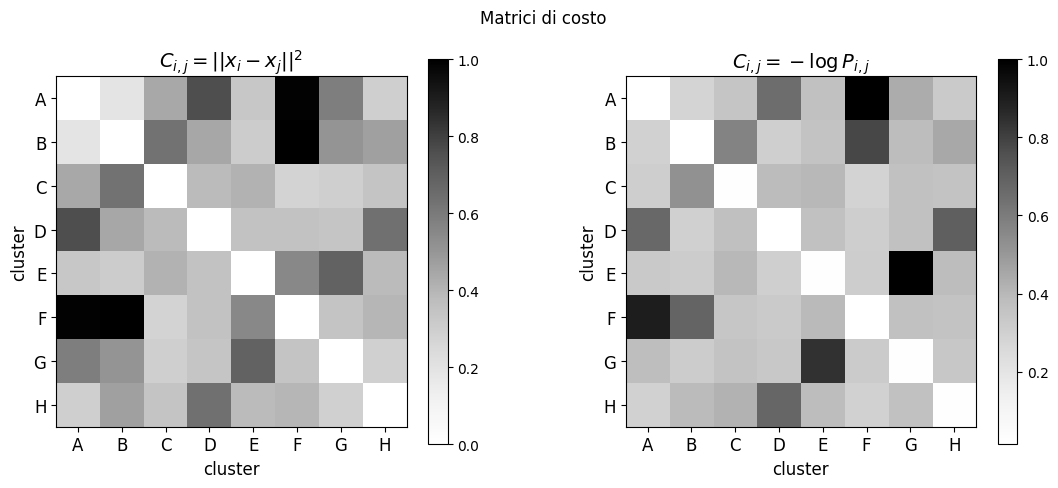

In [4]:
import matplotlib.colors as mcolors
fig,(ax1, ax2) =plt.subplots(1,2, figsize = (13,5))
fig.subplots_adjust(wspace=0.3)
im1=ax1.imshow(cost_sqeuclidean, cmap='Greys')
ax1.set_title(r'$C_{i,j}=||x_i-x_j||^{2}$', fontsize=14)
positions=np.arange(n_cluster)
ax1.set_xlabel("cluster", fontsize=12)
ax1.set_ylabel("cluster", fontsize=12)
ax1.set_xticks(positions)
ax1.set_xticklabels(['A','B','C','D','E','F','G','H'], fontsize=12)
ax1.set_yticks(positions)
ax1.set_yticklabels(['A','B','C','D','E','F','G','H'], fontsize=12)
cbar1 = fig.colorbar(im1)

im2=ax2.imshow(log_transition_probability, cmap='Greys')
ax2.set_title(r'$C_{i,j}=-\log{P_{i,j}}$', fontsize =14)
ax2.set_xlabel("cluster", fontsize=12)
ax2.set_ylabel("cluster", fontsize=12)
ax2.set_xticks(positions)
ax2.set_xticklabels(['A','B','C','D','E','F','G','H'], fontsize=12)
ax2.set_yticks(positions)
ax2.set_yticklabels(['A','B','C','D','E','F','G','H'], fontsize=12)
cbar2 = fig.colorbar(im2)

plt.suptitle('Matrici di costo')
plt.savefig("fMRIconc_matrici.eps")

### Analisi con l'algoritmo di Sinkhorn 

struttura del file imput:  subj, task, cluster. prob

reo DataFrame "results_df" per salvare i costi di trasporto

4 colonne: 'Soggetto', 'task', 'cost'

ci sono due recordings del resting state per ciascun soggetto. prendo la media.

In [7]:
epsilon = 0.01
n_iterazioni_massime = 10000

# Load the CSV file into a DataFrame
file_path = 'clusters_occurrence_k_8.csv'
df = pd.read_csv(file_path)
df.fillna(0, inplace=True)

indici_soggetti=df['subj'].values
indici_soggetti = np.unique(indici_soggetti)
n_soggetti = len(indici_soggetti)

rest1_temp = np.zeros(n_cluster)
rest2_temp = np.zeros(n_cluster)
rest_temp = np.zeros(n_cluster)
emotion_temp = np.zeros(n_cluster)
gambling_temp = np.zeros(n_cluster)
language_temp = np.zeros(n_cluster)
motor_temp = np.zeros(n_cluster)
relational_temp = np.zeros(n_cluster)
social_temp = np.zeros(n_cluster)
wm_temp = np.zeros(n_cluster) #wm== working memory test

###
costs_euclidea_emotion = np.zeros(n_soggetti)
costs_euclidea_gambling = np.zeros(n_soggetti)
costs_euclidea_language = np.zeros(n_soggetti)
costs_euclidea_motor = np.zeros(n_soggetti)
costs_euclidea_relational = np.zeros(n_soggetti)
costs_euclidea_social = np.zeros(n_soggetti)
costs_euclidea_wm = np.zeros(n_soggetti)
######
costs_logprob_emotion = np.zeros(n_soggetti)
costs_logprob_gambling = np.zeros(n_soggetti)
costs_logprob_language = np.zeros(n_soggetti)
costs_logprob_motor = np.zeros(n_soggetti)
costs_logprob_relational = np.zeros(n_soggetti)
costs_logprob_social = np.zeros(n_soggetti)
costs_logprob_wm = np.zeros(n_soggetti)

#definizione dataframe per i risultati
results_cols_names = ['subj', 'task', 'cost']
results_df = pd.DataFrame(index=range(n_soggetti*7), columns=results_cols_names)
results_logprob_df = pd.DataFrame(index=range(n_soggetti*7), columns=results_cols_names)

soggetti_eseguiti = -1
for indice in indici_soggetti:

        soggetti_eseguiti += 1

        rest1_df = df[df['subj'] == indice]
        rest1_df = rest1_df[rest1_df['task']== 'REST1']
        for k in np.arange(n_cluster):
                rest1_temp[k] = rest1_df.iloc[0,k+2]
        
        rest2_df = df[df['subj'] == indice]
        rest2_df = rest2_df[rest2_df['task']== 'REST2']
        for k in np.arange(n_cluster):
                rest2_temp[k] = rest2_df.iloc[0,k+2]

        emotion_df = df[df['subj'] == indice]
        emotion_df = emotion_df[emotion_df['task']== 'EMOTION']
        for k in np.arange(n_cluster):
                emotion_temp[k] = emotion_df.iloc[0,k+2]

        gambling_df = df[df['subj'] == indice]
        gambling_df = gambling_df[gambling_df['task']== 'GAMBLING']
        for k in np.arange(n_cluster):
                gambling_temp[k] = gambling_df.iloc[0,k+2]

        language_df = df[df['subj'] == indice]
        language_df = language_df[language_df['task']== 'LANGUAGE']
        for k in np.arange(n_cluster):
                language_temp[k] = language_df.iloc[0,k+2]
        
        motor_df = df[df['subj'] == indice]
        motor_df = motor_df[motor_df['task']== 'MOTOR']
        for k in np.arange(n_cluster):
                motor_temp[k] = motor_df.iloc[0,k+2]
        
        relational_df = df[df['subj'] == indice]
        relational_df = relational_df[relational_df['task']== 'RELATIONAL']
        for k in np.arange(n_cluster):
                relational_temp[k] = relational_df.iloc[0,k+2]
        
        social_df = df[df['subj'] == indice]
        social_df = social_df[social_df['task']== 'SOCIAL']
        
        for k in np.arange(n_cluster):
                social_temp[k] = social_df.iloc[0,k+2]
        
        wm_df = df[df['subj'] == indice]
        wm_df = wm_df[wm_df['task']== 'WM']
        for k in np.arange(n_cluster):
                wm_temp[k] = wm_df.iloc[0,k+2]

        #media tra distribuzioni al resting
        rest_temp = (rest1_temp + rest2_temp)/2

        #calcola e salva i costi di trasporto

        ###################### EMOTION ##################################
        G, costo = mysinkhorn.sinkhorn_solver(rest_temp, emotion_temp, cost_sqeuclidean, epsilon, n_iterazioni_massime)
        results_df.loc[7*soggetti_eseguiti + 0, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 0, 'task'] = 'EMOTION'
        results_df.loc[7*soggetti_eseguiti + 0, 'cost'] = costo
        costs_euclidea_emotion[soggetti_eseguiti] = costo

        G, costo = mysinkhorn.sinkhorn_solver(rest_temp, emotion_temp, log_transition_probability, epsilon, n_iterazioni_massime)
        results_logprob_df.loc[7*soggetti_eseguiti + 0, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 0, 'task'] = 'EMOTION'
        results_logprob_df.loc[7*soggetti_eseguiti + 0, 'cost'] = costo
        costs_logprob_emotion[soggetti_eseguiti] = costo

        #################### GAMBLING #############################
        G, costo = mysinkhorn.sinkhorn_solver(rest_temp, gambling_temp, cost_sqeuclidean, epsilon, n_iterazioni_massime)
        results_df.loc[7*soggetti_eseguiti + 1, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 1, 'task'] = 'GAMBLING'
        results_df.loc[7*soggetti_eseguiti + 1, 'cost'] = costo
        costs_euclidea_gambling[soggetti_eseguiti] = costo

        G, costo = mysinkhorn.sinkhorn_solver(rest_temp, gambling_temp, log_transition_probability, epsilon, n_iterazioni_massime)
        results_logprob_df.loc[7*soggetti_eseguiti + 1, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 1, 'task'] = 'GAMBLING'
        results_logprob_df.loc[7*soggetti_eseguiti + 1, 'cost'] = costo
        costs_logprob_gambling[soggetti_eseguiti] = costo

        ################### LANGUAGE #############################
        G, costo = mysinkhorn.sinkhorn_solver(rest_temp, language_temp, cost_sqeuclidean, epsilon, n_iterazioni_massime)
        results_df.loc[7*soggetti_eseguiti + 2, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 2, 'task'] = 'LANGUAGE'
        results_df.loc[7*soggetti_eseguiti + 2, 'cost'] = costo
        costs_euclidea_language[soggetti_eseguiti] = costo

        G, costo = mysinkhorn.sinkhorn_solver(rest_temp, language_temp, log_transition_probability, epsilon, n_iterazioni_massime)
        results_logprob_df.loc[7*soggetti_eseguiti + 2, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 2, 'task'] = 'LANGUAGE'
        results_logprob_df.loc[7*soggetti_eseguiti + 2, 'cost'] = costo
        costs_logprob_language[soggetti_eseguiti] = costo
        
        #################### MOTOR #################################
        G, costo = mysinkhorn.sinkhorn_solver(rest_temp, motor_temp, cost_sqeuclidean, epsilon, n_iterazioni_massime)
        results_df.loc[7*soggetti_eseguiti + 3, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 3, 'task'] = 'MOTOR'
        results_df.loc[7*soggetti_eseguiti + 3, 'cost'] = costo
        costs_euclidea_motor[soggetti_eseguiti] = costo

        G, costo = mysinkhorn.sinkhorn_solver(rest_temp, motor_temp, log_transition_probability, epsilon, n_iterazioni_massime)
        results_logprob_df.loc[7*soggetti_eseguiti + 3, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 3, 'task'] = 'MOTOR'
        results_logprob_df.loc[7*soggetti_eseguiti + 3, 'cost'] = costo
        costs_logprob_motor[soggetti_eseguiti] = costo

        ################# RELATIONAL ###############################
        G, costo = mysinkhorn.sinkhorn_solver(rest_temp, relational_temp, cost_sqeuclidean, epsilon, n_iterazioni_massime)
        results_df.loc[7*soggetti_eseguiti + 4, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 4, 'task'] = 'RELATIONAL'
        results_df.loc[7*soggetti_eseguiti + 4, 'cost'] = costo
        costs_euclidea_relational[soggetti_eseguiti] = costo

        G, costo = mysinkhorn.sinkhorn_solver(rest_temp, relational_temp, log_transition_probability, epsilon, n_iterazioni_massime)
        results_logprob_df.loc[7*soggetti_eseguiti + 4, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 4, 'task'] = 'RELATIONAL'
        results_logprob_df.loc[7*soggetti_eseguiti + 4, 'cost'] = costo
        costs_logprob_relational[soggetti_eseguiti] = costo

        ################ SOCIAL #################################
        G, costo = mysinkhorn.sinkhorn_solver(rest_temp, social_temp, cost_sqeuclidean, epsilon, n_iterazioni_massime)
        results_df.loc[7*soggetti_eseguiti + 5, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 5, 'task'] = 'SOCIAL'
        results_df.loc[7*soggetti_eseguiti + 5, 'cost'] = costo
        costs_euclidea_social[soggetti_eseguiti] = costo

        G, costo = mysinkhorn.sinkhorn_solver(rest_temp, social_temp, log_transition_probability, epsilon, n_iterazioni_massime)
        results_logprob_df.loc[7*soggetti_eseguiti + 5, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 5, 'task'] = 'SOCIAL'
        results_logprob_df.loc[7*soggetti_eseguiti + 5, 'cost'] = costo
        costs_logprob_social[soggetti_eseguiti] = costo
        ############## WM #############################################
        G, costo = mysinkhorn.sinkhorn_solver(rest_temp, wm_temp, cost_sqeuclidean, epsilon, n_iterazioni_massime)
        results_df.loc[7*soggetti_eseguiti + 6, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 6, 'task'] = 'WM'
        results_df.loc[7*soggetti_eseguiti + 6, 'cost'] = costo
        costs_euclidea_wm[soggetti_eseguiti] = costo

        G, costo = mysinkhorn.sinkhorn_solver(rest_temp, wm_temp, log_transition_probability, epsilon, n_iterazioni_massime)
        results_logprob_df.loc[7*soggetti_eseguiti + 6, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 6, 'task'] = 'WM'
        results_logprob_df.loc[7*soggetti_eseguiti + 6, 'cost'] = costo
        costs_logprob_wm[soggetti_eseguiti] = costo
        ####################################################################

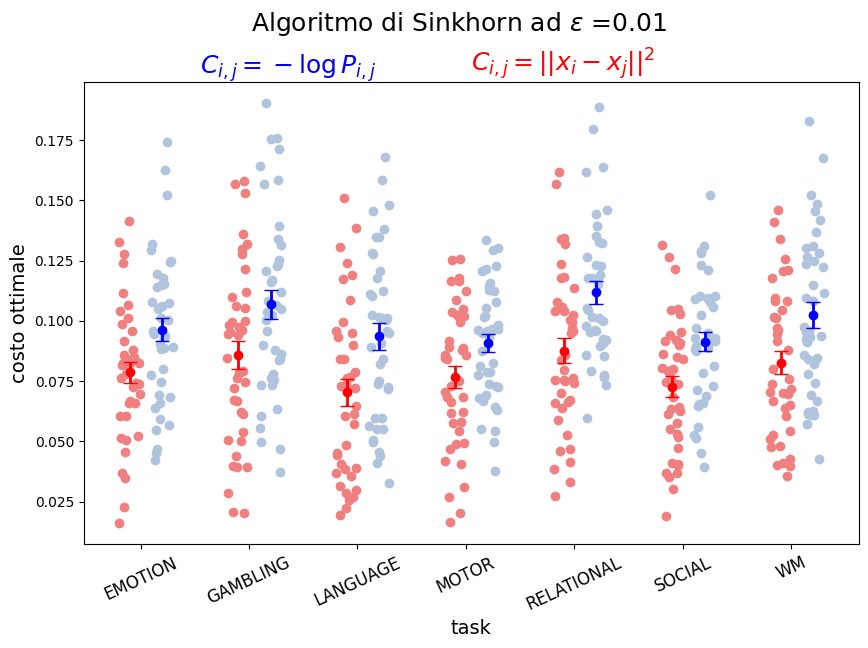

In [134]:
nomi_task = ['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']
fig, ax1 = plt.subplots( figsize = (10, 6))

counter = -1

medie = [] #lista di liste
errore_medie = []
medie_logprob = [] #lista di liste
errore_medie_logprob = []

for a in nomi_task:
        counter += 1

        prova = results_df[results_df['task']==a]
        prova_cost=prova['cost'].values
        media = prova_cost.mean(); medie += [a, media],
        errore_media = prova_cost.std()/np.sqrt(prova_cost.size); errore_medie += [a, errore_media],
        ax1.scatter(np.random.uniform(counter-0.2, counter, prova_cost.size), prova_cost , color='lightcoral')
        ax1.errorbar(counter-0.1, media, yerr= errore_media, marker='o', markersize=6, color='red',  capsize=5, elinewidth=2)

        prova = results_logprob_df[results_logprob_df['task']==a]
        prova_cost=prova['cost'].values
        media = prova_cost.mean(); medie_logprob += [a, media],
        errore_media = prova_cost.std()/np.sqrt(prova_cost.size); errore_medie_logprob += [a, errore_media],
        ax1.scatter(np.random.uniform(counter+0.1, counter+0.3, prova_cost.size), prova_cost , color='lightsteelblue')
        ax1.errorbar(counter+0.2, media, yerr= errore_media, marker='o', markersize=6, color='blue', capsize=5, elinewidth=2)

xpositions=np.arange(0, 7)
ax1.set_xlabel("task", fontsize=14)
ax1.set_ylabel("costo ottimale", fontsize=14)
ax1.set_xticks(xpositions)
ax1.set_xticklabels(['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM'], fontsize = 12, rotation = 25)
# Setting the first part of the title
ax1.set_title(r'$C_{i,j}=||x_i-x_j||^{2}$', fontsize=18, color='red', ha = 'left')

# Adding the second part of the title using text method
ax1.text(0.15, 1.018, r"$C_{i,j}=-\log{P_{i,j}}$", transform=ax1.transAxes, fontsize=18, color='blue', ha='left')


plt.suptitle(fr'Algoritmo di Sinkhorn ad $\epsilon$ ={epsilon}', fontsize=18, y=1)
plt.savefig(f'fMRIconc_scatterplot_epsilon={epsilon}.eps')
plt.savefig(f'fMRIconc_scatterplot_epsilon={epsilon}.svg')
plt.savefig(f'fMRIconc_scatterplot_epsilon={epsilon}.pdf')

Istogramma delle task ordinate per costo crescente, con matrice del test di student tra coppie

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_1995/2064531762.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, fontsize = 12, rotation = 60)
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_1995/2064531762.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(labels, fontsize = 12, rotation = 60)


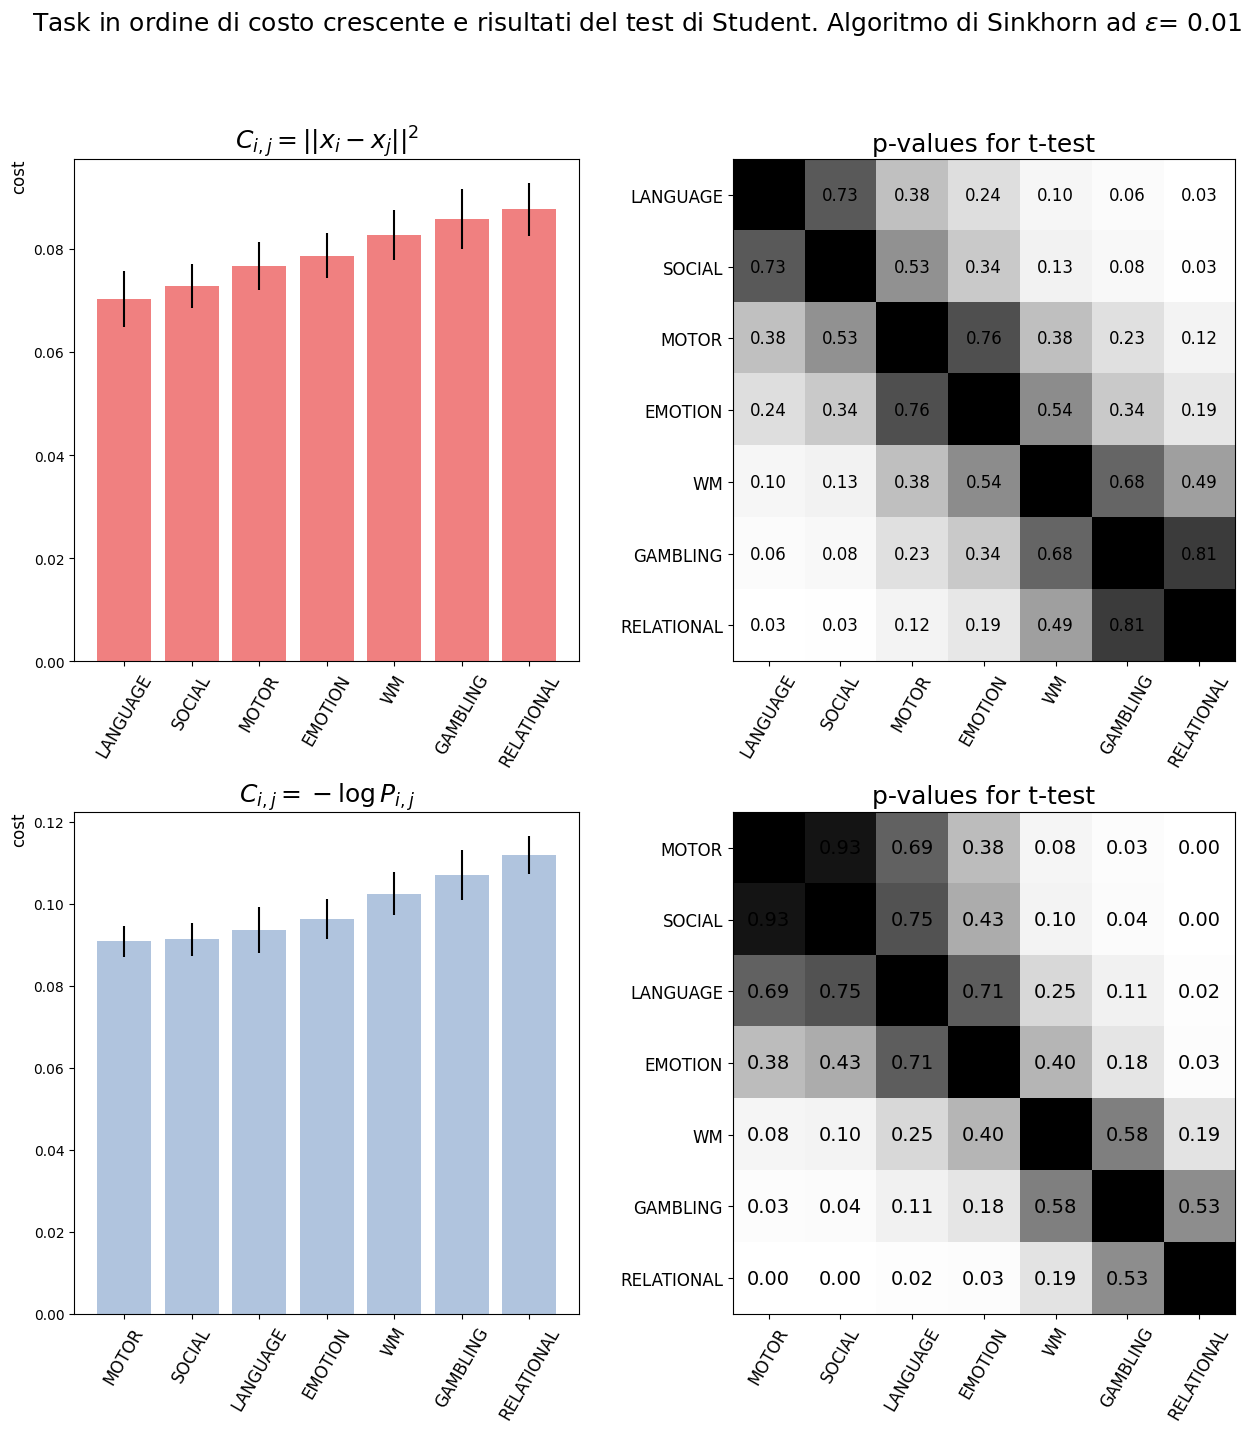

In [63]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))
plt.subplots_adjust(wspace = 0.3, hspace= 0.3)

############################ matrice di costo EUCLIDEA #########################################################
sorted_medie = sorted(medie, key=lambda x: x[1])
sorted_errore_medie = sorted(errore_medie, key=lambda x: [item[0] for item in sorted_medie].index(x[0]))

labels, values = zip(*sorted_medie)
errors =  [item[1] for item in sorted_errore_medie]

# Plot the histogram
ax1.bar(labels, values, yerr= errors, color= 'lightcoral')
ax1.set_xticklabels(labels, fontsize = 12, rotation = 60)
ax1.set_ylabel('cost', loc= 'top', fontsize = 12)
ax1.set_title(r'$C_{i,j}=||x_i-x_j||^{2}$', fontsize=18)

#t test
pvalues=np.zeros((7,7))
counter_rows = -1
for a in labels:
    counter_cols = -1
    counter_rows += 1
    for b in labels:
        counter_cols += 1
        prova1 = results_df[results_df['task']==a]
        prova1_cost=np.array(prova1['cost'].values)

        prova2 = results_df[results_df['task']==b]
        prova2_cost=np.array(prova2['cost'].values)

        ttest=stats.ttest_ind(prova1_cost.tolist(), prova2_cost.tolist())
        pvalues[counter_rows,counter_cols]=ttest.pvalue

ax2.set_title("p-values for t-test", fontsize = 18)
im=ax2.imshow(pvalues, cmap='Grays')
ax2.set_xticks(xpositions)
ax2.set_xticklabels(labels, rotation = 60, fontsize = 12)
ax2.set_yticks(xpositions)
ax2.set_yticklabels(labels, fontsize = 12)

# Display the values within each cell
for i in range(pvalues.shape[0]):
    for j in range(pvalues.shape[1]):
        text = ax2.text(j, i, f'{pvalues[i, j]:.2f}', ha='center', va='center', color='black', fontsize=12)


######################################## matrice di costo LOGPROB ##############################################################

sorted_medie_logprob = sorted(medie_logprob, key=lambda x: x[1])
sorted_errore_medie_logprob = sorted(errore_medie_logprob, key=lambda x: [item[0] for item in sorted_medie_logprob].index(x[0]))

labels, values = zip(*sorted_medie_logprob)
errors =  [item[1] for item in sorted_errore_medie_logprob]

# Plot the histogram
ax3.bar(labels, values, yerr= errors, color= 'lightsteelblue')
ax3.set_xticklabels(labels, fontsize = 12, rotation = 60)
ax3.set_ylabel('cost', loc= 'top', fontsize = 12)
ax3.set_title(r'$C_{i,j}=-\log{P_{i,j}}$', fontsize =18)

#t test
pvalues=np.zeros((7,7))
counter_rows = -1
for a in labels:
    counter_cols = -1
    counter_rows += 1
    for b in labels:
        counter_cols += 1
        prova1 = results_logprob_df[results_logprob_df['task']==a]
        prova1_cost=np.array(prova1['cost'].values)

        prova2 = results_logprob_df[results_logprob_df['task']==b]
        prova2_cost=np.array(prova2['cost'].values)

        ttest=stats.ttest_ind(prova1_cost.tolist(), prova2_cost.tolist())
        pvalues[counter_rows,counter_cols]=ttest.pvalue

ax4.set_title("p-values for t-test", fontsize = 18)
im=ax4.imshow(pvalues, cmap='Grays')
ax4.set_xticks(xpositions)
ax4.set_xticklabels(labels, rotation = 60, fontsize = 12)
ax4.set_yticks(xpositions)
ax4.set_yticklabels(labels, fontsize = 12)

# Display the values within each cell
for i in range(pvalues.shape[0]):
    for j in range(pvalues.shape[1]):
        text = ax4.text(j, i, f'{pvalues[i, j]:.2f}', ha='center', va='center', color='black', fontsize=14)


plt.suptitle(fr'Task in ordine di costo crescente e risultati del test di Student. Algoritmo di Sinkhorn ad $\epsilon$= {epsilon}', fontsize=18)
plt.savefig(f"fMRIconc_ordine_pvalue_epsilon={epsilon}.eps")
plt.savefig(f"fMRIconc_ordine_pvalue_epsilon={epsilon}.png")

ONE WAY ANOVA TEST

In [58]:
f_oneway(costs_euclidea_wm, costs_euclidea_emotion, costs_euclidea_social, costs_euclidea_gambling, costs_euclidea_language,costs_euclidea_motor, costs_euclidea_relational)

F_onewayResult(statistic=1.6631573684628178, pvalue=0.13013364914763142)

In [59]:
f_oneway(costs_logprob_wm, costs_logprob_emotion, costs_logprob_social, costs_logprob_gambling, costs_logprob_language,costs_logprob_motor, costs_logprob_relational)

F_onewayResult(statistic=2.5944093532604566, pvalue=0.018406263392103227)

ASIMMETRIA DEL COSTO

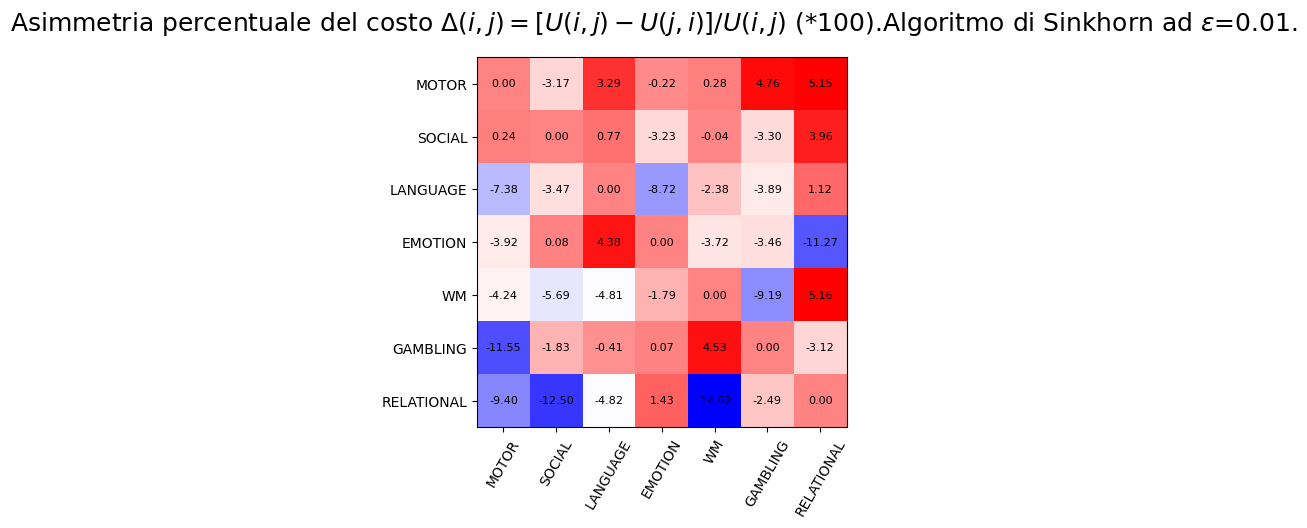

In [64]:
#import ot
fig, ax2 = plt.subplots()
asymmetry_matrix = np.zeros((7,7))
temp1 = np.zeros(n_cluster)
temp2 = np.zeros(n_cluster)
################################## matrice di costo EUCLIDEA ################################################

#labels, values = zip(*sorted_medie)
#
#soggetti_eseguiti = -1
#for indice in indici_soggetti:
#        soggetti_eseguiti += 1
#        counter_rows = -1
#        for a in labels:
#                nome_task = a
#                counter_rows += 1
#                temp1_df = df[(df['subj'] == indice) & (df['task'] ==nome_task)]
#                temp1_values = temp1_df.iloc[:, 2:].values
#                inner_list1 = temp1_values[0]
#                # Convert the inner list to a NumPy array
#                temp1 = np.array(inner_list1)
#                counter_cols = -1       
#                for b in labels:
#                        counter_cols += 1
#                        if(counter_rows == counter_cols):
#                              asymmetry_matrix[counter_rows,counter_cols] = 0
#                        else:
#                                temp2_df = df[(df['subj'] == indice) & (df['task'] == b)]
#                                temp2_values = temp2_df.iloc[:, 2:].values
#                                inner_list2 = temp2_values[0]
#                                # Convert the inner list to a NumPy array
#                                temp2 = np.array(inner_list2)
#                                # Calcolo i costi
#                                G1, costo1 = mysinkhorn.sinkhorn_solver(temp1,temp2, cost_sqeuclidean, epsilon, n_iterazioni_massime)
#                                G2, costo2 = mysinkhorn.sinkhorn_solver(temp2,temp1, cost_sqeuclidean, epsilon, n_iterazioni_massime)
#                                #G1 = ot.sinkhorn(temp1,temp2, cost_sqeuclidean, epsilon)
#                                #matbis = np.multiply(G1, cost_sqeuclidean)
#                                #costo1 = np.sum(matbis)
#                                #G2, costo2 = mysinkhorn.sinkhorn_solver(temp2,temp1, cost_sqeuclidean, epsilon, n_iterazioni_massime)
#                                #G2 = ot.sinkhorn(temp2,temp1, cost_sqeuclidean, epsilon)
#                                #matbis = np.multiply(G2, cost_sqeuclidean)
#                                #costo2 = np.sum(matbis)
#                                asymmetry_matrix[counter_rows][counter_cols] += (costo1- costo2)/costo1
#
#asymmetry_matrix = asymmetry_matrix/n_soggetti
#asymmetry_matrix = asymmetry_matrix*100
#for i in range(asymmetry_matrix.shape[0]):
#    for j in range(asymmetry_matrix.shape[1]):
#          if asymmetry_matrix[i,j]<1:
#                asymmetry_matrix[i,j] = 0
#im1=ax1.imshow(asymmetry_matrix, cmap='Grays')
#ax1.set_xticks(xpositions)
#ax1.set_xticklabels(labels, rotation = 60)
#ax1.set_yticks(xpositions)
#ax1.set_yticklabels(labels)

#Display the values within each cell
#for i in range(asymmetry_matrix.shape[0]):
#    for j in range(asymmetry_matrix.shape[1]):
#        text = ax1.text(j, i, f'{asymmetry_matrix[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)

######################################## matrice di costo LOGPROB #################################################

 
labels, values = zip(*sorted_medie_logprob)

soggetti_eseguiti = -1
for indice in indici_soggetti:
        soggetti_eseguiti += 1
        counter_rows = -1
        for a in labels:
                nome_task = a
                counter_rows += 1
                temp1_df = df[(df['subj'] == indice) & (df['task'] ==nome_task)]
                temp1_values = temp1_df.iloc[:, 2:].values
                inner_list1 = temp1_values[0]
                # Convert the inner list to a NumPy array
                temp1 = np.array(inner_list1)
                counter_cols = -1       
                for b in labels:
                        counter_cols += 1
                        if(counter_rows == counter_cols):
                              asymmetry_matrix[counter_rows,counter_cols] = 0
                        else:
                                temp2_df = df[(df['subj'] == indice) & (df['task'] == b)]
                                temp2_values = temp2_df.iloc[:, 2:].values
                                inner_list2 = temp2_values[0]
                                # Convert the inner list to a NumPy array
                                temp2 = np.array(inner_list2)
                                # Calcolo i costi
                                G1, costo1 = mysinkhorn.sinkhorn_solver(temp1,temp2, log_transition_probability, epsilon, n_iterazioni_massime)
                                G2, costo2 = mysinkhorn.sinkhorn_solver(temp2,temp1, log_transition_probability, epsilon, n_iterazioni_massime)
                                #G1 = ot.sinkhorn(temp1,temp2, log_transition_probability, epsilon)
                                #matbis = np.multiply(G1, log_transition_probability)
                                #costo1 = np.sum(matbis)
                                #G2 = ot.sinkhorn(temp2,temp1, log_transition_probability, epsilon)
                                #matbis = np.multiply(G2, log_transition_probability)
                                #costo2 = np.sum(matbis)
                                asymmetry_matrix[counter_rows][counter_cols] += ( costo1 - costo2 )/costo1

asymmetry_matrix = asymmetry_matrix/n_soggetti
asymmetry_matrix = asymmetry_matrix*100
im2=ax2.imshow(asymmetry_matrix, cmap='bwr')
ax2.set_xticks(xpositions)
ax2.set_xticklabels(labels, rotation = 60)
ax2.set_yticks(xpositions)
ax2.set_yticklabels(labels)

#Display the values within each cell
for i in range(asymmetry_matrix.shape[0]):
    for j in range(asymmetry_matrix.shape[1]):
        text = ax2.text(j, i, f'{asymmetry_matrix[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)

###################################################################################################################################       

# Show the plot  
plt.subplots_adjust(wspace=0.4)
plt.suptitle(fr"Asimmetria percentuale del costo $\Delta(i,j)=[U(i,j)-U(j,i)] / U(i,j)$ (*100).Algoritmo di Sinkhorn ad $\epsilon$={epsilon}.", fontsize = 18)

plt.savefig(f"fMRIconc_asimmetria_epsilon_{epsilon}.eps")
plt.savefig(f"fMRIconc_asimmetria_epsilon_{epsilon}.png")

### Analisi con algoritmo EMD (soluzione esatta di Kanthorovich)

In [71]:
import ot

file_path = 'clusters_occurrence_k_8.csv'
df = pd.read_csv(file_path)
df.fillna(0, inplace=True)

indici_soggetti=df['subj'].values
indici_soggetti = np.unique(indici_soggetti)
n_soggetti = len(indici_soggetti)

### creo array numpy del tipo task_temp = np.zeros(n_cluster)############
variables = ['rest1', 'rest2', 'rest', 'emotion', 'gambling', 'language', 'motor', 'relational', 'social', 'wm']
temp_dict = {var+'_temp': np.zeros(n_cluster) for var in variables}
### creo array numpy del tipo costs_euclidea_temp = np.zeros(n_soggetti)  e costs_euclidea_temp = np.zeros(n_soggetti)##########
categories = ['emotion', 'gambling', 'language', 'motor', 'relational', 'social', 'wm']
costs_euclidea = {cat: np.zeros(n_soggetti) for cat in categories}
costs_logprob = {cat: np.zeros(n_soggetti) for cat in categories}

#definizione dataframe per i risultati
results_cols_names = ['subj', 'task', 'cost']
results_df = pd.DataFrame(index=range(n_soggetti*7), columns=results_cols_names)
results_logprob_df = pd.DataFrame(index=range(n_soggetti*7), columns=results_cols_names)

soggetti_eseguiti = -1
for indice in indici_soggetti:

        soggetti_eseguiti += 1

        rest1_df = df[df['subj'] == indice]
        rest1_df = rest1_df[rest1_df['task']== 'REST1']
        for k in np.arange(n_cluster):
                rest1_temp[k] = rest1_df.iloc[0,k+2]
        
        rest2_df = df[df['subj'] == indice]
        rest2_df = rest2_df[rest2_df['task']== 'REST2']
        for k in np.arange(n_cluster):
                rest2_temp[k] = rest2_df.iloc[0,k+2]

        emotion_df = df[df['subj'] == indice]
        emotion_df = emotion_df[emotion_df['task']== 'EMOTION']
        for k in np.arange(n_cluster):
                emotion_temp[k] = emotion_df.iloc[0,k+2]

        gambling_df = df[df['subj'] == indice]
        gambling_df = gambling_df[gambling_df['task']== 'GAMBLING']
        for k in np.arange(n_cluster):
                gambling_temp[k] = gambling_df.iloc[0,k+2]

        language_df = df[df['subj'] == indice]
        language_df = language_df[language_df['task']== 'LANGUAGE']
        for k in np.arange(n_cluster):
                language_temp[k] = language_df.iloc[0,k+2]
        
        motor_df = df[df['subj'] == indice]
        motor_df = motor_df[motor_df['task']== 'MOTOR']
        for k in np.arange(n_cluster):
                motor_temp[k] = motor_df.iloc[0,k+2]
        
        relational_df = df[df['subj'] == indice]
        relational_df = relational_df[relational_df['task']== 'RELATIONAL']
        for k in np.arange(n_cluster):
                relational_temp[k] = relational_df.iloc[0,k+2]
        
        social_df = df[df['subj'] == indice]
        social_df = social_df[social_df['task']== 'SOCIAL']
        
        for k in np.arange(n_cluster):
                social_temp[k] = social_df.iloc[0,k+2]
        
        wm_df = df[df['subj'] == indice]
        wm_df = wm_df[wm_df['task']== 'WM']
        for k in np.arange(n_cluster):
                wm_temp[k] = wm_df.iloc[0,k+2]

        #media tra distribuzioni al resting
        rest_temp = (rest1_temp + rest2_temp)/2

        #calcola e salva i costi di trasporto

        ###################### EMOTION ##################################
        Gemd=ot.emd(rest_temp, emotion_temp, cost_sqeuclidean)
        matbis=np.multiply(cost_sqeuclidean,Gemd)
        costoemd=np.sum(matbis)
        results_df.loc[7*soggetti_eseguiti + 0, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 0, 'task'] = 'EMOTION'
        results_df.loc[7*soggetti_eseguiti + 0, 'cost'] = costoemd
        costs_euclidea_emotion[soggetti_eseguiti] = costoemd

        Gemd=ot.emd(rest_temp, emotion_temp, log_transition_probability)
        matbis=np.multiply(cost_sqeuclidean,Gemd)
        costoemd=np.sum(matbis)
        results_logprob_df.loc[7*soggetti_eseguiti + 0, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 0, 'task'] = 'EMOTION'
        results_logprob_df.loc[7*soggetti_eseguiti + 0, 'cost'] = costoemd
        costs_logprob_emotion[soggetti_eseguiti] = costoemd

        #################### GAMBLING #############################
        Gemd=ot.emd(rest_temp, gambling_temp, cost_sqeuclidean)
        matbis=np.multiply(cost_sqeuclidean,Gemd)
        costoemd=np.sum(matbis)
        results_df.loc[7*soggetti_eseguiti + 1, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 1, 'task'] = 'GAMBLING'
        results_df.loc[7*soggetti_eseguiti + 1, 'cost'] = costoemd
        costs_euclidea_gambling[soggetti_eseguiti] = costoemd

        Gemd=ot.emd(rest_temp, gambling_temp, log_transition_probability)
        matbis=np.multiply(cost_sqeuclidean,Gemd)
        costoemd=np.sum(matbis)
        results_logprob_df.loc[7*soggetti_eseguiti + 1, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 1, 'task'] = 'GAMBLING'
        results_logprob_df.loc[7*soggetti_eseguiti + 1, 'cost'] = costoemd
        costs_logprob_gambling[soggetti_eseguiti] = costoemd

        ################### LANGUAGE #############################
        Gemd=ot.emd(rest_temp, language_temp, cost_sqeuclidean)
        matbis=np.multiply(cost_sqeuclidean,Gemd)
        costoemd=np.sum(matbis)
        results_df.loc[7*soggetti_eseguiti + 2, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 2, 'task'] = 'LANGUAGE'
        results_df.loc[7*soggetti_eseguiti + 2, 'cost'] = costoemd
        costs_euclidea_language[soggetti_eseguiti] = costoemd

        Gemd=ot.emd(rest_temp, language_temp, log_transition_probability)
        matbis=np.multiply(cost_sqeuclidean,Gemd)
        costoemd=np.sum(matbis)
        results_logprob_df.loc[7*soggetti_eseguiti + 2, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 2, 'task'] = 'LANGUAGE'
        results_logprob_df.loc[7*soggetti_eseguiti + 2, 'cost'] = costoemd
        costs_logprob_language[soggetti_eseguiti] = costoemd
        
        #################### MOTOR #################################
        Gemd=ot.emd(rest_temp, motor_temp, cost_sqeuclidean)
        matbis=np.multiply(cost_sqeuclidean,Gemd)
        costoemd=np.sum(matbis)
        results_df.iloc[7 * soggetti_eseguiti + 3, results_df.columns.get_indexer(['subj', 'task', 'cost'])] = [indice, 'MOTOR', costoemd]
        costs_euclidea_motor[soggetti_eseguiti] = costoemd

        Gemd=ot.emd(rest_temp, motor_temp, log_transition_probability)
        matbis=np.multiply(cost_sqeuclidean,Gemd)
        costoemd=np.sum(matbis)
        results_logprob_df.loc[7*soggetti_eseguiti + 3, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 3, 'task'] = 'MOTOR'
        results_logprob_df.loc[7*soggetti_eseguiti + 3, 'cost'] = costoemd
        costs_logprob_motor[soggetti_eseguiti] = costoemd

        ################# RELATIONAL ###############################
        Gemd=ot.emd(rest_temp, relational_temp, cost_sqeuclidean)
        matbis=np.multiply(cost_sqeuclidean,Gemd)
        costoemd=np.sum(matbis)
        results_df.loc[7*soggetti_eseguiti + 4, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 4, 'task'] = 'RELATIONAL'
        results_df.loc[7*soggetti_eseguiti + 4, 'cost'] = costoemd
        costs_euclidea_relational[soggetti_eseguiti] = costoemd

        Gemd=ot.emd(rest_temp, relational_temp, log_transition_probability)
        matbis=np.multiply(cost_sqeuclidean,Gemd)
        costoemd=np.sum(matbis)
        results_logprob_df.loc[7*soggetti_eseguiti + 4, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 4, 'task'] = 'RELATIONAL'
        results_logprob_df.loc[7*soggetti_eseguiti + 4, 'cost'] = costoemd
        costs_logprob_relational[soggetti_eseguiti] = costoemd

        ################ SOCIAL #################################
        Gemd=ot.emd(rest_temp, social_temp, cost_sqeuclidean)
        matbis=np.multiply(cost_sqeuclidean,Gemd)
        costoemd=np.sum(matbis)
        results_df.loc[7*soggetti_eseguiti + 5, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 5, 'task'] = 'SOCIAL'
        results_df.loc[7*soggetti_eseguiti + 5, 'cost'] = costoemd
        costs_euclidea_social[soggetti_eseguiti] = costoemd

        Gemd=ot.emd(rest_temp, social_temp, log_transition_probability)
        matbis=np.multiply(cost_sqeuclidean,Gemd)
        costoemd=np.sum(matbis)
        results_logprob_df.loc[7*soggetti_eseguiti + 5, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 5, 'task'] = 'SOCIAL'
        results_logprob_df.loc[7*soggetti_eseguiti + 5, 'cost'] = costoemd
        costs_logprob_social[soggetti_eseguiti] = costoemd
        ############## WM #############################################
        Gemd=ot.emd(rest_temp, wm_temp, cost_sqeuclidean)
        matbis=np.multiply(cost_sqeuclidean,Gemd)
        costoemd=np.sum(matbis)
        results_df.loc[7*soggetti_eseguiti + 6, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 6, 'task'] = 'WM'
        results_df.loc[7*soggetti_eseguiti + 6, 'cost'] = costoemd
        costs_euclidea_wm[soggetti_eseguiti] = costoemd

        Gemd=ot.emd(rest_temp, wm_temp, log_transition_probability)
        matbis=np.multiply(cost_sqeuclidean,Gemd)
        costoemd=np.sum(matbis)
        results_logprob_df.loc[7*soggetti_eseguiti + 6, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 6, 'task'] = 'WM'
        results_logprob_df.loc[7*soggetti_eseguiti + 6, 'cost'] = costoemd
        costs_logprob_wm[soggetti_eseguiti] = costoemd
        ####################################################################

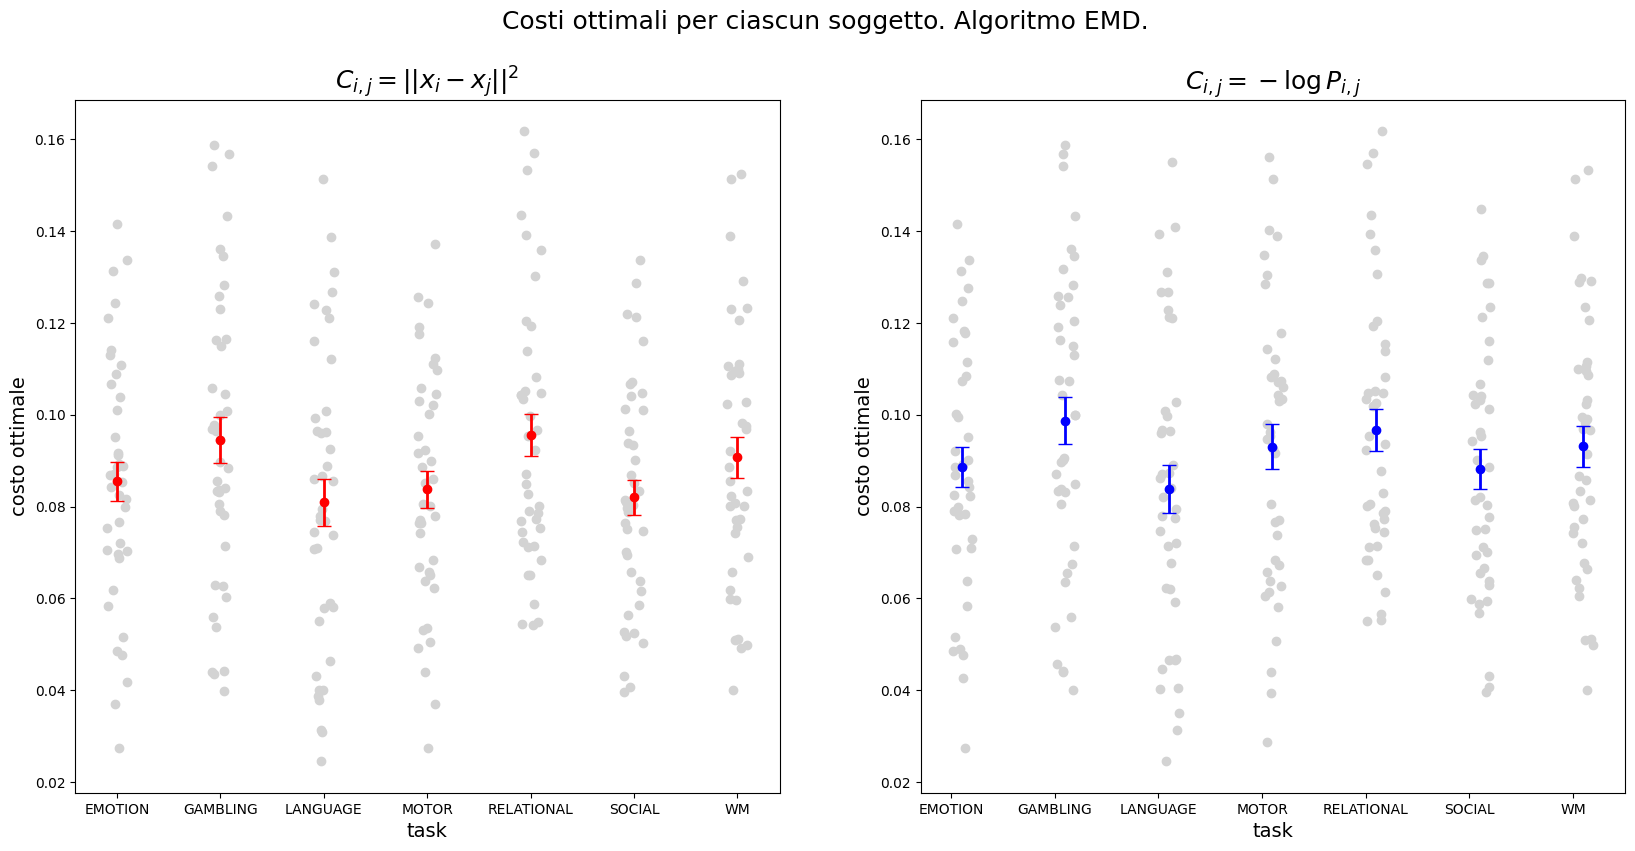

In [72]:
nomi_task = ['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 9))

counter = -1

medie = [] #lista di liste
errore_medie = []
medie_logprob = [] #lista di liste
errore_medie_logprob = []

for a in nomi_task:
        counter += 1

        prova = results_df[results_df['task']==a]
        prova_cost=prova['cost'].values
        media = prova_cost.mean(); medie += [a, media],
        errore_media = prova_cost.std()/np.sqrt(prova_cost.size); errore_medie += [a, errore_media],
        ax1.scatter(np.random.uniform(counter-0.1, counter+0.1, prova_cost.size), prova_cost , color='lightgray')
        ax1.errorbar(counter, media, yerr= errore_media, marker='o', markersize=6, color='red',  capsize=5, elinewidth=2)

        prova = results_logprob_df[results_logprob_df['task']==a]
        prova_cost=prova['cost'].values
        media = prova_cost.mean(); medie_logprob += [a, media],
        errore_media = prova_cost.std()/np.sqrt(prova_cost.size); errore_medie_logprob += [a, errore_media],
        ax2.scatter(np.random.uniform(counter, counter+0.2, prova_cost.size), prova_cost , color='lightgray')
        ax2.errorbar(counter+0.1, media, yerr= errore_media, marker='o', markersize=6, color='blue', capsize=5, elinewidth=2)

xpositions=np.arange(0, 7)
ax1.set_xlabel("task", fontsize=14)
ax1.set_ylabel("costo ottimale", fontsize=14)
ax1.set_xticks(xpositions)
ax1.set_xticklabels(['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM'])
ax1.set_title(r'$C_{i,j}=||x_i-x_j||^{2}$', fontsize=18)

xpositions=np.arange(0, 7)
ax2.set_xlabel("task", fontsize=14)
ax2.set_ylabel("costo ottimale", fontsize=14)
ax2.set_xticks(xpositions)
ax2.set_xticklabels(['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM'])
ax2.set_title(r'$C_{i,j}=-\log{P_{i,j}}$', fontsize =18)

plt.suptitle(fr'Costi ottimali per ciascun soggetto. Algoritmo EMD.', fontsize=18)
plt.savefig('fMRIconc_scatterplot_EMD.eps')
plt.savefig('fMRIconc_scatterplot_EMD.png')

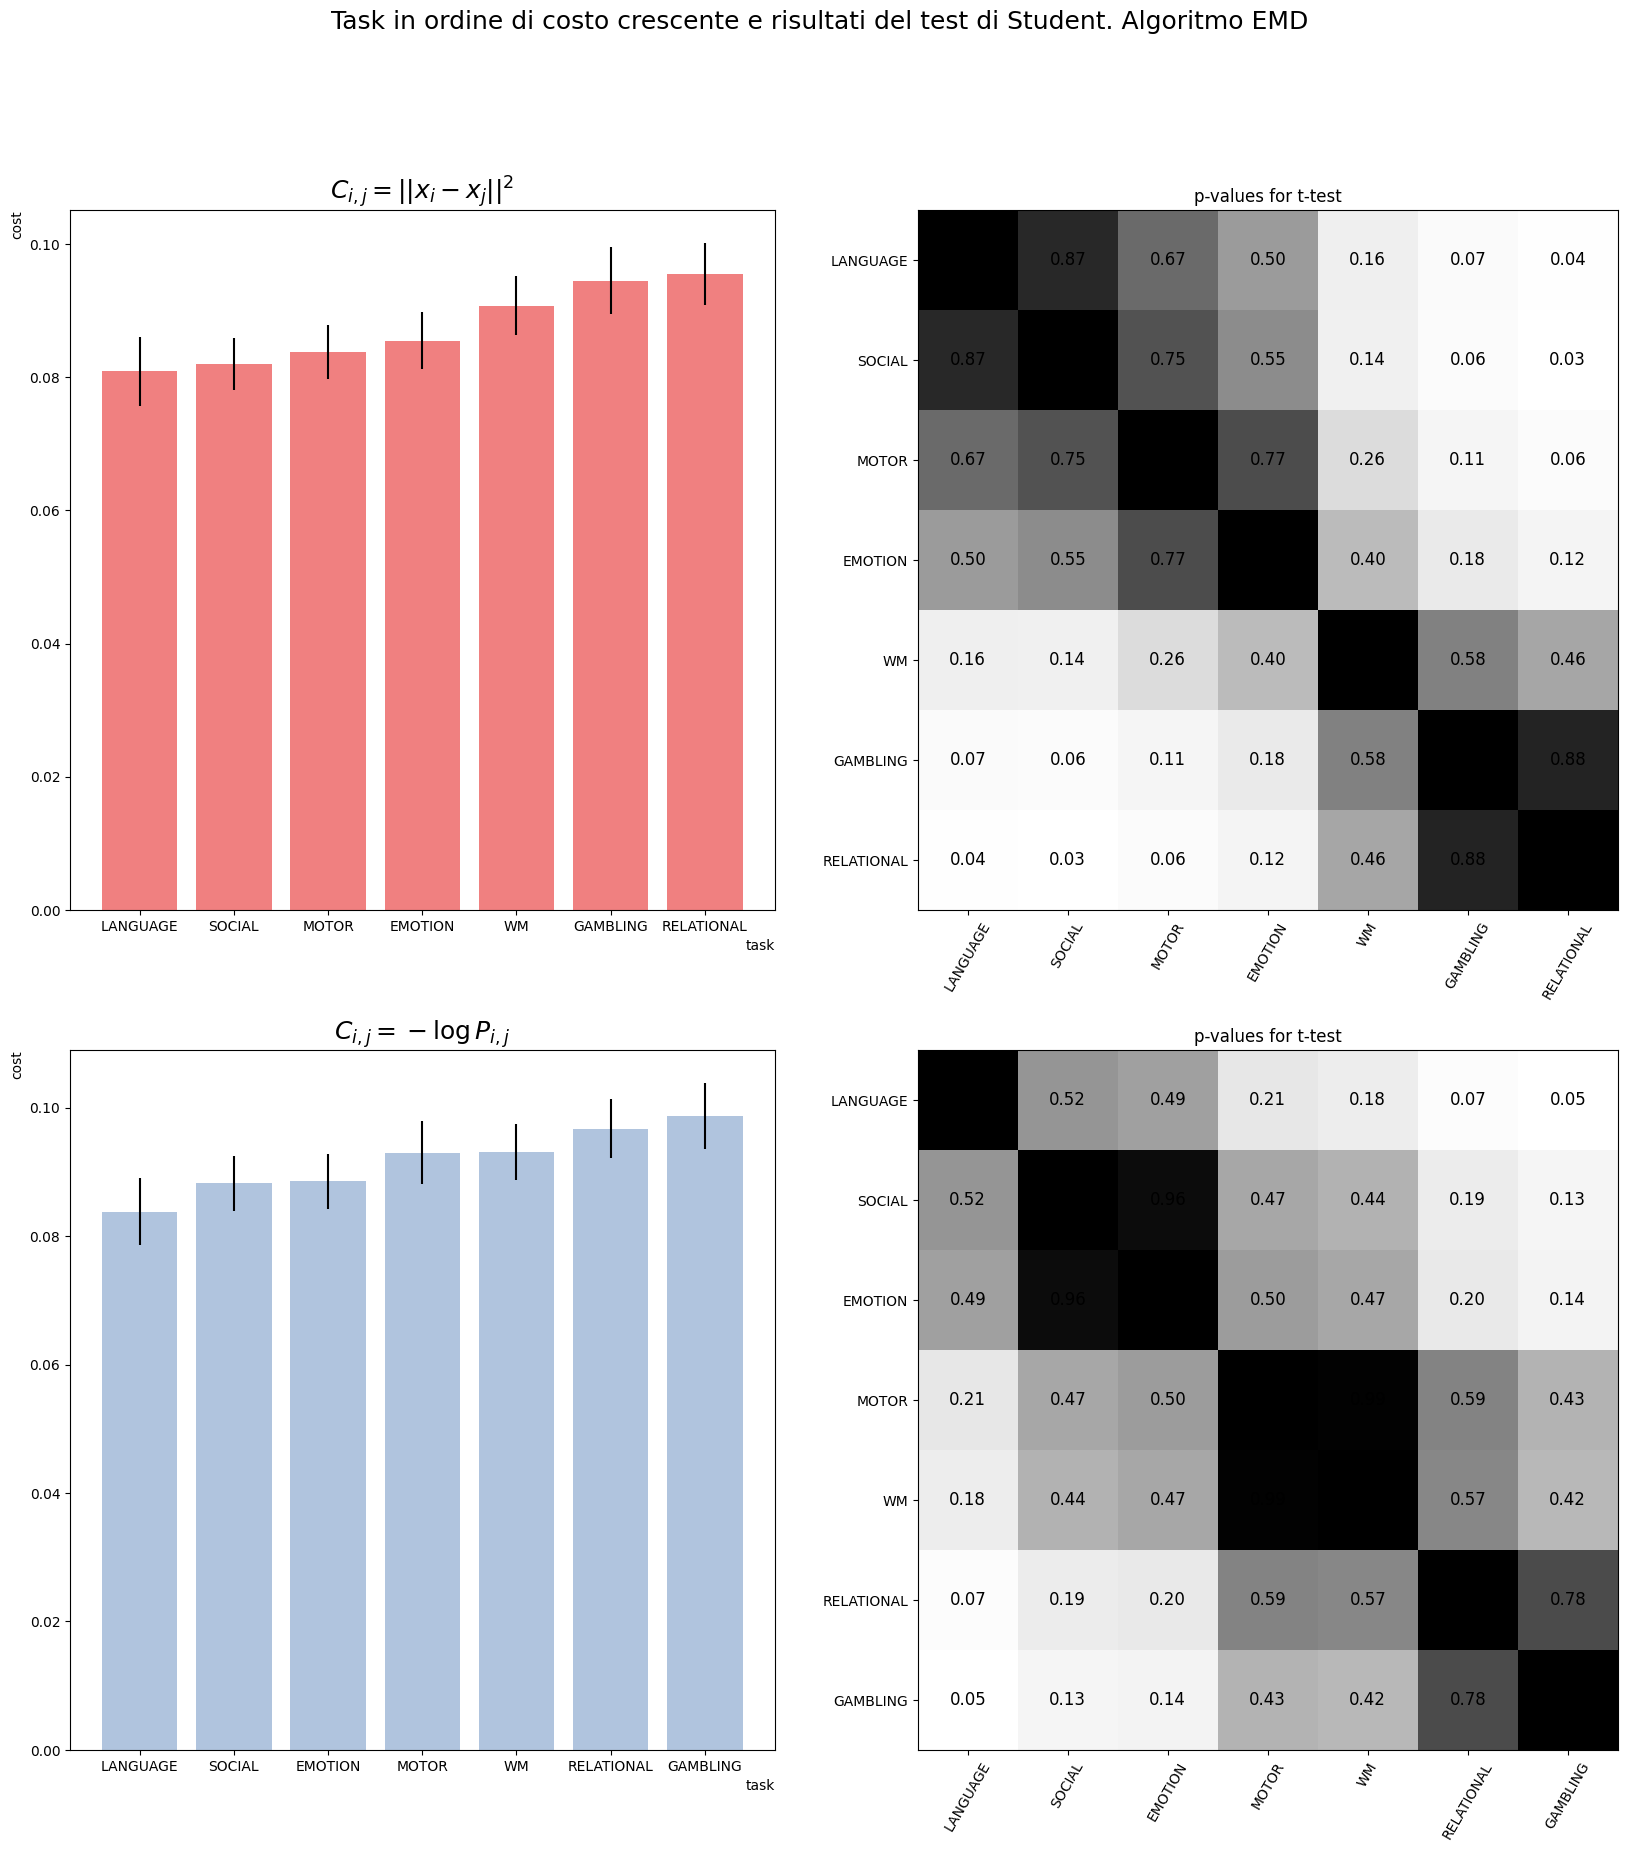

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,20))


############################ matrice di costo EUCLIDEA #########################################################
sorted_medie = sorted(medie, key=lambda x: x[1])
sorted_errore_medie = sorted(errore_medie, key=lambda x: [item[0] for item in sorted_medie].index(x[0]))

labels, values = zip(*sorted_medie)
errors =  [item[1] for item in sorted_errore_medie]

# Plot the histogram
ax1.bar(labels, values, yerr= errors, color= 'lightcoral')
ax1.set_xlabel('task', loc= 'right' )
ax1.set_ylabel('cost', loc= 'top')
ax1.set_title(r'$C_{i,j}=||x_i-x_j||^{2}$', fontsize=18)

#t test
pvalues=np.zeros((7,7))
counter_rows = -1
for a in labels:
    counter_cols = -1
    counter_rows += 1
    for b in labels:
        counter_cols += 1
        prova1 = results_df[results_df['task']==a]
        prova1_cost=np.array(prova1['cost'].values)

        prova2 = results_df[results_df['task']==b]
        prova2_cost=np.array(prova2['cost'].values)

        ttest=stats.ttest_ind(prova1_cost.tolist(), prova2_cost.tolist())
        pvalues[counter_rows,counter_cols]=ttest.pvalue

ax2.set_title("p-values for t-test")
im=ax2.imshow(pvalues, cmap='Grays')
ax2.set_xticks(xpositions)
ax2.set_xticklabels(labels, rotation = 60)
ax2.set_yticks(xpositions)
ax2.set_yticklabels(labels)

# Display the values within each cell
for i in range(pvalues.shape[0]):
    for j in range(pvalues.shape[1]):
        text = ax2.text(j, i, f'{pvalues[i, j]:.2f}', ha='center', va='center', color='black', fontsize=12)


######################################## matrice di costo LOGPROB ##############################################################

sorted_medie_logprob = sorted(medie_logprob, key=lambda x: x[1])
sorted_errore_medie_logprob = sorted(errore_medie_logprob, key=lambda x: [item[0] for item in sorted_medie_logprob].index(x[0]))

labels, values = zip(*sorted_medie_logprob)
errors =  [item[1] for item in sorted_errore_medie_logprob]

# Plot the histogram
ax3.bar(labels, values, yerr= errors, color= 'lightsteelblue')
ax3.set_xlabel('task', loc= 'right' )
ax3.set_ylabel('cost', loc= 'top')
ax3.set_title(r'$C_{i,j}=-\log{P_{i,j}}$', fontsize =18)

#t test
pvalues=np.zeros((7,7))
counter_rows = -1
for a in labels:
    counter_cols = -1
    counter_rows += 1
    for b in labels:
        counter_cols += 1
        prova1 = results_logprob_df[results_logprob_df['task']==a]
        prova1_cost=np.array(prova1['cost'].values)

        prova2 = results_logprob_df[results_logprob_df['task']==b]
        prova2_cost=np.array(prova2['cost'].values)

        ttest=stats.ttest_ind(prova1_cost.tolist(), prova2_cost.tolist())
        pvalues[counter_rows,counter_cols]=ttest.pvalue

ax4.set_title("p-values for t-test")
im=ax4.imshow(pvalues, cmap='Grays')
ax4.set_xticks(xpositions)
ax4.set_xticklabels(labels, rotation = 60)
ax4.set_yticks(xpositions)
ax4.set_yticklabels(labels)

# Display the values within each cell
for i in range(pvalues.shape[0]):
    for j in range(pvalues.shape[1]):
        text = ax4.text(j, i, f'{pvalues[i, j]:.2f}', ha='center', va='center', color='black', fontsize=12)


plt.suptitle(fr'Task in ordine di costo crescente e risultati del test di Student. Algoritmo EMD', fontsize=18)
plt.savefig("fMRIconc_ordine_pvalue_EMD.eps")
plt.savefig("fMRIconc_ordine_pvalue_EMD.png")

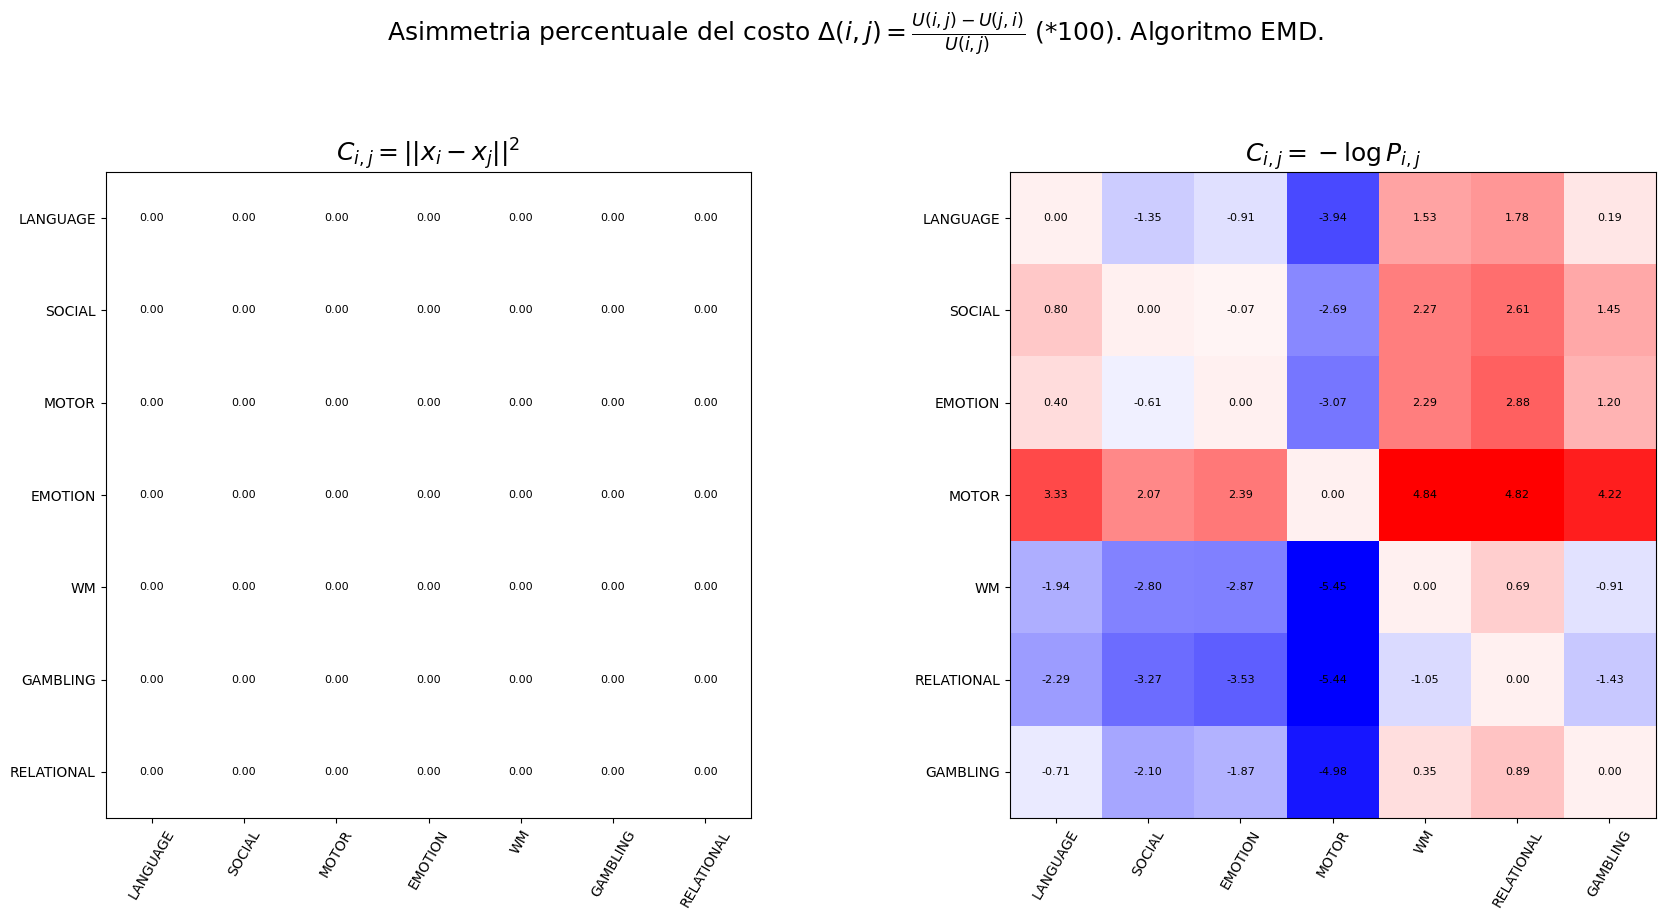

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
asymmetry_matrix = np.zeros((7,7))
temp1 = np.zeros(n_cluster)
temp2 = np.zeros(n_cluster)
################################## matrice di costo EUCLIDEA ################################################

labels, values = zip(*sorted_medie)

soggetti_eseguiti = -1
for indice in indici_soggetti:
        soggetti_eseguiti += 1
        counter_rows = -1
        for a in labels:
                nome_task = a
                counter_rows += 1
                temp1_df = df[(df['subj'] == indice) & (df['task'] ==nome_task)]
                temp1_values = temp1_df.iloc[:, 2:].values
                inner_list1 = temp1_values[0]
                # Convert the inner list to a NumPy array
                temp1 = np.array(inner_list1)
                counter_cols = -1       
                for b in labels:
                        counter_cols += 1
                        if(counter_rows == counter_cols):
                               asymmetry_matrix[counter_rows][counter_cols] = 0
                        else:
                                temp2_df = df[(df['subj'] == indice) & (df['task'] == b)]
                                temp2_values = temp2_df.iloc[:, 2:].values
                                inner_list2 = temp2_values[0]
                                # Convert the inner list to a NumPy array
                                temp2 = np.array(inner_list2)
                                # Calcolo i costi
                                G1 = ot.emd(temp1,temp2, cost_sqeuclidean)
                                matbis = np.multiply(G1, cost_sqeuclidean)
                                costo1 = np.sum(matbis)
                                G2 = ot.emd(temp2,temp1, cost_sqeuclidean)
                                matbis = np.multiply(G2, cost_sqeuclidean)
                                costo2 = np.sum(matbis)
                                asymmetry_matrix[counter_rows][counter_cols] += (costo1 - costo2)/costo1

asymmetry_matrix = asymmetry_matrix/n_soggetti
asymmetry_matrix = asymmetry_matrix*100
for i in range(asymmetry_matrix.shape[0]):
    for j in range(asymmetry_matrix.shape[1]):
        if asymmetry_matrix[i,j]<1:
               asymmetry_matrix[i,j] = 0

im1=ax1.imshow(asymmetry_matrix, cmap='Grays')
ax1.set_xticks(xpositions)
ax1.set_xticklabels(labels, rotation = 60)
ax1.set_yticks(xpositions)
ax1.set_yticklabels(labels)
ax1.set_title(r'$C_{i,j}= ||x_i-x_j||^{2}$', fontsize =18)

#Display the values within each cell
for i in range(asymmetry_matrix.shape[0]):
    for j in range(asymmetry_matrix.shape[1]):
        text = ax1.text(j, i, f'{asymmetry_matrix[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)

######################################## matrice di costo LOGPROB #################################################

 
labels, values = zip(*sorted_medie_logprob)

soggetti_eseguiti = -1
for indice in indici_soggetti:
        soggetti_eseguiti += 1
        counter_rows = -1
        for a in labels:
                nome_task = a
                counter_rows += 1
                temp1_df = df[(df['subj'] == indice) & (df['task'] ==nome_task)]
                temp1_values = temp1_df.iloc[:, 2:].values
                inner_list1 = temp1_values[0]
                # Convert the inner list to a NumPy array
                temp1 = np.array(inner_list1)
                counter_cols = -1       
                for b in labels:
                        counter_cols += 1
                        if(counter_rows == counter_cols):
                               asymmetry_matrix[counter_rows][counter_cols] = 0
                        else:
                                temp2_df = df[(df['subj'] == indice) & (df['task'] == b)]
                                temp2_values = temp2_df.iloc[:, 2:].values
                                inner_list2 = temp2_values[0]
                                # Convert the inner list to a NumPy array
                                temp2 = np.array(inner_list2)
                                # Calcolo i costi
                                G1 = ot.emd(temp1,temp2, log_transition_probability)
                                matbis = np.multiply(G1, log_transition_probability)
                                costo1 = np.sum(matbis)
                                G2 = ot.emd(temp2,temp1, log_transition_probability)
                                matbis = np.multiply(G2, log_transition_probability)
                                costo2 = np.sum(matbis)
                                asymmetry_matrix[counter_rows][counter_cols] += (costo1 - costo2)/costo1

asymmetry_matrix = asymmetry_matrix/n_soggetti
asymmetry_matrix = asymmetry_matrix*100
im2=ax2.imshow(asymmetry_matrix, cmap='bwr')
ax2.set_xticks(xpositions)
ax2.set_xticklabels(labels, rotation = 60)
ax2.set_yticks(xpositions)
ax2.set_yticklabels(labels)

#Display the values within each cell
for i in range(asymmetry_matrix.shape[0]):
    for j in range(asymmetry_matrix.shape[1]):
        text = ax2.text(j, i, f'{asymmetry_matrix[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)

ax2.set_title(r'$C_{i,j}=-\log{P_{i,j}}$', fontsize =18)
###################################################################################################################################       

# Show the plot  
plt.subplots_adjust(wspace=0.4)
plt.suptitle(r"Asimmetria percentuale del costo $\Delta(i,j)=\frac{U(i,j)-U(j,i)}{U(i,j)}$ (*100). Algoritmo EMD.", fontsize = 18)

plt.savefig("fMRIconc_asimmetria_EMD.eps")
plt.savefig("fMRIconc_asimmetria_EMD.png")

### Analisi con l'algoritmo FREE_ENERGY

In [8]:
from freeot import FreeOT
instance = FreeOT()

epsilon_start = 0.0001
epsilon_stop = 0.0001

beta_stop = 1/epsilon_stop

# Load the CSV file into a DataFrame
file_path = 'clusters_occurrence_k_8.csv'
df = pd.read_csv(file_path)
df.fillna(0, inplace=True)

indici_soggetti=df['subj'].values
indici_soggetti = np.unique(indici_soggetti)
n_soggetti = len(indici_soggetti)

### creo array numpy del tipo task_temp = np.zeros(n_cluster)############
variables = ['rest1', 'rest2', 'rest', 'emotion', 'gambling', 'language', 'motor', 'relational', 'social', 'wm']
temp_dict = {var+'_temp': np.zeros(n_cluster) for var in variables}
### creo array numpy del tipo costs_euclidea_temp = np.zeros(n_soggetti)  e costs_euclidea_temp = np.zeros(n_soggetti)##########
categories = ['emotion', 'gambling', 'language', 'motor', 'relational', 'social', 'wm']
costs_euclidea = {cat: np.zeros(n_soggetti) for cat in categories}
costs_logprob = {cat: np.zeros(n_soggetti) for cat in categories}

#definizione dataframe per i risultati
results_cols_names = ['subj', 'task', 'cost']
results_df = pd.DataFrame(index=range(n_soggetti*7), columns=results_cols_names)
results_logprob_df = pd.DataFrame(index=range(n_soggetti*7), columns=results_cols_names)

soggetti_eseguiti = -1
for indice in indici_soggetti:

        soggetti_eseguiti += 1

        rest1_df = df[df['subj'] == indice]
        rest1_df = rest1_df[rest1_df['task']== 'REST1']
        for k in np.arange(n_cluster):
                rest1_temp[k] = rest1_df.iloc[0,k+2]
        
        rest2_df = df[df['subj'] == indice]
        rest2_df = rest2_df[rest2_df['task']== 'REST2']
        for k in np.arange(n_cluster):
                rest2_temp[k] = rest2_df.iloc[0,k+2]

        emotion_df = df[df['subj'] == indice]
        emotion_df = emotion_df[emotion_df['task']== 'EMOTION']
        for k in np.arange(n_cluster):
                emotion_temp[k] = emotion_df.iloc[0,k+2]

        gambling_df = df[df['subj'] == indice]
        gambling_df = gambling_df[gambling_df['task']== 'GAMBLING']
        for k in np.arange(n_cluster):
                gambling_temp[k] = gambling_df.iloc[0,k+2]

        language_df = df[df['subj'] == indice]
        language_df = language_df[language_df['task']== 'LANGUAGE']
        for k in np.arange(n_cluster):
                language_temp[k] = language_df.iloc[0,k+2]
        
        motor_df = df[df['subj'] == indice]
        motor_df = motor_df[motor_df['task']== 'MOTOR']
        for k in np.arange(n_cluster):
                motor_temp[k] = motor_df.iloc[0,k+2]
        
        relational_df = df[df['subj'] == indice]
        relational_df = relational_df[relational_df['task']== 'RELATIONAL']
        for k in np.arange(n_cluster):
                relational_temp[k] = relational_df.iloc[0,k+2]
        
        social_df = df[df['subj'] == indice]
        social_df = social_df[social_df['task']== 'SOCIAL']
        
        for k in np.arange(n_cluster):
                social_temp[k] = social_df.iloc[0,k+2]
        
        wm_df = df[df['subj'] == indice]
        wm_df = wm_df[wm_df['task']== 'WM']
        for k in np.arange(n_cluster):
                wm_temp[k] = wm_df.iloc[0,k+2]

        #media tra distribuzioni al resting
        rest_temp = (rest1_temp + rest2_temp)/2

        #calcola e salva i costi di trasporto

        ###################### EMOTION ##################################
        G, costo=instance.solve(rest_temp, emotion_temp, cost_sqeuclidean, epsilon_start, epsilon_stop)
        results_df.loc[7*soggetti_eseguiti + 0, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 0, 'task'] = 'EMOTION'
        results_df.loc[7*soggetti_eseguiti + 0, 'cost'] = costo
        costs_euclidea_emotion[soggetti_eseguiti] = costo

        G, costo=instance.solve(rest_temp, emotion_temp, log_transition_probability, epsilon_start, epsilon_stop)
        results_logprob_df.loc[7*soggetti_eseguiti + 0, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 0, 'task'] = 'EMOTION'
        results_logprob_df.loc[7*soggetti_eseguiti + 0, 'cost'] = costo
        costs_logprob_emotion[soggetti_eseguiti] = costo

        #################### GAMBLING #############################
        G, costo=instance.solve(rest_temp, gambling_temp, cost_sqeuclidean, epsilon_start, epsilon_stop)
        results_df.loc[7*soggetti_eseguiti + 1, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 1, 'task'] = 'GAMBLING'
        results_df.loc[7*soggetti_eseguiti + 1, 'cost'] = costo
        costs_euclidea_gambling[soggetti_eseguiti] = costo

        G, costo=instance.solve(rest_temp, gambling_temp, log_transition_probability, epsilon_start, epsilon_stop)
        results_logprob_df.loc[7*soggetti_eseguiti + 1, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 1, 'task'] = 'GAMBLING'
        results_logprob_df.loc[7*soggetti_eseguiti + 1, 'cost'] = costo
        costs_logprob_gambling[soggetti_eseguiti] = costo

        ################### LANGUAGE #############################
        G, costo=instance.solve(rest_temp, language_temp, cost_sqeuclidean, epsilon_start, epsilon_stop)
        results_df.loc[7*soggetti_eseguiti + 2, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 2, 'task'] = 'LANGUAGE'
        results_df.loc[7*soggetti_eseguiti + 2, 'cost'] = costo
        costs_euclidea_language[soggetti_eseguiti] = costo

        G, costo=instance.solve(rest_temp, language_temp, log_transition_probability, epsilon_start, epsilon_stop)
        results_logprob_df.loc[7*soggetti_eseguiti + 2, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 2, 'task'] = 'LANGUAGE'
        results_logprob_df.loc[7*soggetti_eseguiti + 2, 'cost'] = costo
        costs_logprob_language[soggetti_eseguiti] = costo
        
        #################### MOTOR #################################
        G, costo=instance.solve(rest_temp, motor_temp, cost_sqeuclidean, epsilon_start, epsilon_stop)
        results_df.loc[7*soggetti_eseguiti + 3, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 3, 'task'] = 'MOTOR'
        results_df.loc[7*soggetti_eseguiti + 3, 'cost'] = costo
        costs_euclidea_motor[soggetti_eseguiti] = costo

        G, costo=instance.solve(rest_temp, motor_temp, log_transition_probability, epsilon_start, epsilon_stop)
        results_logprob_df.loc[7*soggetti_eseguiti + 3, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 3, 'task'] = 'MOTOR'
        results_logprob_df.loc[7*soggetti_eseguiti + 3, 'cost'] = costo
        costs_logprob_motor[soggetti_eseguiti] = costo

        ################# RELATIONAL ###############################
        G, costo=instance.solve(rest_temp, relational_temp, cost_sqeuclidean, epsilon_start, epsilon_stop)
        results_df.loc[7*soggetti_eseguiti + 4, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 4, 'task'] = 'RELATIONAL'
        results_df.loc[7*soggetti_eseguiti + 4, 'cost'] = costo
        costs_euclidea_relational[soggetti_eseguiti] = costo

        G, costo=instance.solve(rest_temp, relational_temp, log_transition_probability, epsilon_start, epsilon_stop)
        results_logprob_df.loc[7*soggetti_eseguiti + 4, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 4, 'task'] = 'RELATIONAL'
        results_logprob_df.loc[7*soggetti_eseguiti + 4, 'cost'] = costo
        costs_logprob_relational[soggetti_eseguiti] = costo

        ################ SOCIAL #################################
        G, costo=instance.solve(rest_temp, social_temp, cost_sqeuclidean, epsilon_start, epsilon_stop)
        results_df.loc[7*soggetti_eseguiti + 5, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 5, 'task'] = 'SOCIAL'
        results_df.loc[7*soggetti_eseguiti + 5, 'cost'] = costo
        costs_euclidea_social[soggetti_eseguiti] = costo

        G, costo=instance.solve(rest_temp, social_temp, log_transition_probability, epsilon_start, epsilon_stop)
        results_logprob_df.loc[7*soggetti_eseguiti + 5, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 5, 'task'] = 'SOCIAL'
        results_logprob_df.loc[7*soggetti_eseguiti + 5, 'cost'] = costo
        costs_logprob_social[soggetti_eseguiti] = costo
        ############## WM #############################################
        G, costo=instance.solve(rest_temp, wm_temp, cost_sqeuclidean, epsilon_start, epsilon_stop)
        results_df.loc[7*soggetti_eseguiti + 6, 'subj'] = indice
        results_df.loc[7*soggetti_eseguiti + 6, 'task'] = 'WM'
        results_df.loc[7*soggetti_eseguiti + 6, 'cost'] = costo
        costs_euclidea_wm[soggetti_eseguiti] = costo

        G, costo=instance.solve(rest_temp, wm_temp, log_transition_probability, epsilon_start, epsilon_stop)
        results_logprob_df.loc[7*soggetti_eseguiti + 6, 'subj'] = indice
        results_logprob_df.loc[7*soggetti_eseguiti + 6, 'task'] = 'WM'
        results_logprob_df.loc[7*soggetti_eseguiti + 6, 'cost'] = costo
        costs_logprob_wm[soggetti_eseguiti] = costo
        ####################################################################

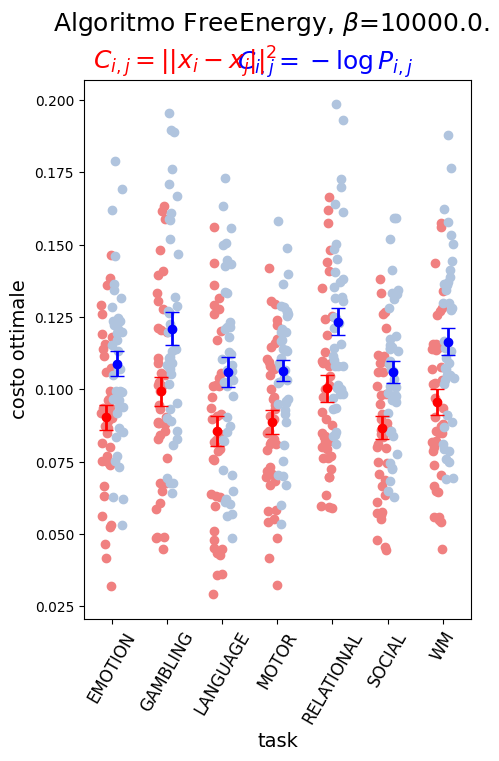

In [9]:
nomi_task = ['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']
fig, ax1 = plt.subplots( figsize = (5,7))

counter = -1

medie = [] #lista di liste
errore_medie = []
medie_logprob = [] #lista di liste
errore_medie_logprob = []

for a in nomi_task:
        counter += 1

        prova = results_df[results_df['task']==a]
        prova_cost=prova['cost'].values
        media = prova_cost.mean(); medie += [a, media],
        errore_media = prova_cost.std()/np.sqrt(prova_cost.size); errore_medie += [a, errore_media],
        ax1.scatter(np.random.uniform(counter-0.2, counter, prova_cost.size), prova_cost , color='lightcoral')
        ax1.errorbar(counter-0.1, media, yerr= errore_media, marker='o', markersize=6, color='red',  capsize=5, elinewidth=2)

        prova = results_logprob_df[results_logprob_df['task']==a]
        prova_cost=prova['cost'].values
        media = prova_cost.mean(); medie_logprob += [a, media],
        errore_media = prova_cost.std()/np.sqrt(prova_cost.size); errore_medie_logprob += [a, errore_media],
        ax1.scatter(np.random.uniform(counter, counter+0.2, prova_cost.size), prova_cost , color='lightsteelblue')
        ax1.errorbar(counter+0.1, media, yerr= errore_media, marker='o', markersize=6, color='blue', capsize=5, elinewidth=2)

xpositions=np.arange(0, 7)
ax1.set_xlabel("task", fontsize=14)
ax1.set_ylabel("costo ottimale", fontsize=14)
ax1.set_xticks(xpositions)
ax1.set_xticklabels(['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM'], fontsize = 12, rotation = 60)
# Setting the first part of the title
ax1.set_title(r'$C_{i,j}=||x_i-x_j||^{2}$', fontsize=18, color='red', ha = 'right')

# Adding the second part of the title using text method
ax1.text(0.85, 1.018, r"$C_{i,j}=-\log{P_{i,j}}$", transform=ax1.transAxes, fontsize=18, color='blue', ha='right')

plt.suptitle(fr'Algoritmo FreeEnergy, $\beta$={beta_stop}.', fontsize=18)
plt.savefig(f'fMRIconc_scatterplot_beta={beta_stop}.eps')
plt.savefig(f'fMRIconc_scatterplot_beta={beta_stop}.svg')
plt.savefig(f'fMRIconc_scatterplot_beta={beta_stop}.pdf')

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_1342/4265388125.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, fontsize= 12, rotation = 60)
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_1342/4265388125.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(labels, fontsize= 12, rotation = 60)


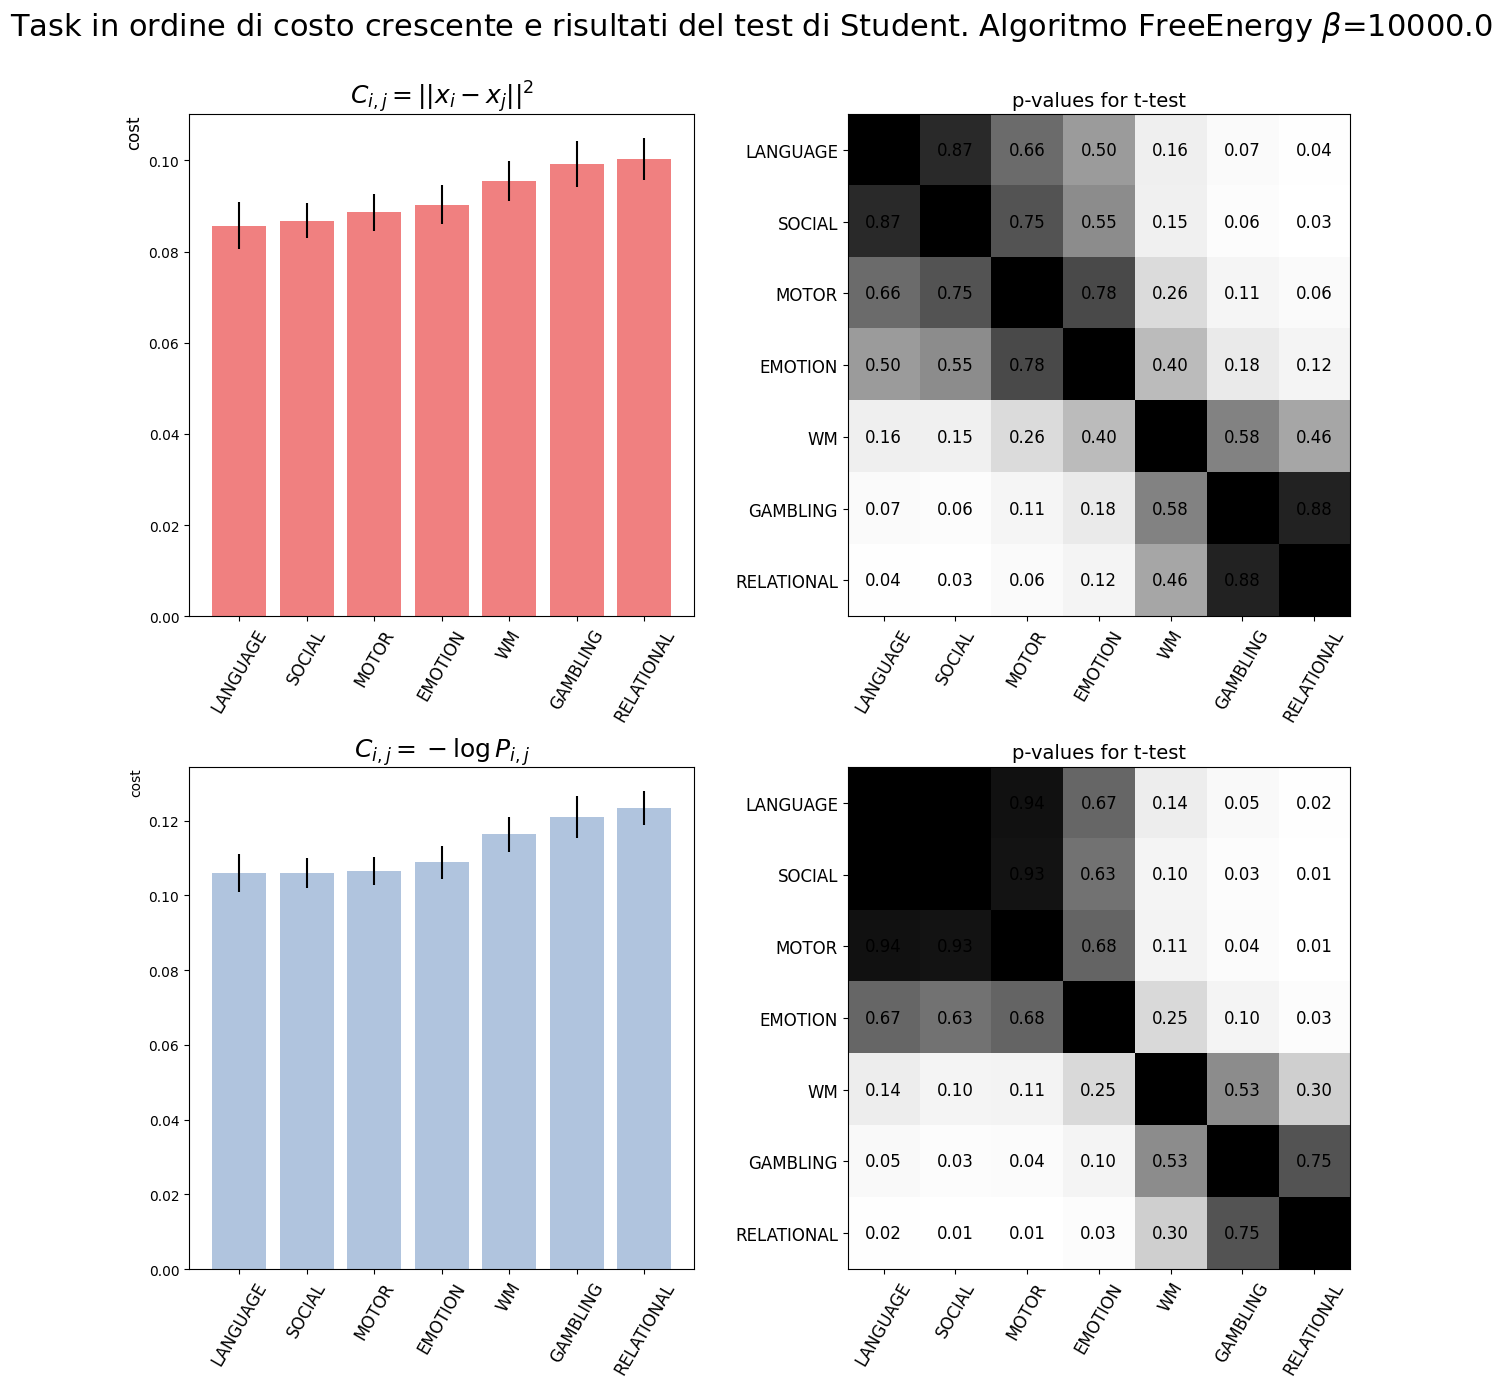

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

############################ matrice di costo EUCLIDEA #########################################################
sorted_medie = sorted(medie, key=lambda x: x[1])
sorted_errore_medie = sorted(errore_medie, key=lambda x: [item[0] for item in sorted_medie].index(x[0]))

labels, values = zip(*sorted_medie)
errors =  [item[1] for item in sorted_errore_medie]

# Plot the histogram
ax1.bar(labels, values, yerr= errors, color= 'lightcoral')
ax1.set_xticklabels(labels, fontsize= 12, rotation = 60)
ax1.set_ylabel('cost', loc= 'top', fontsize = 12)
ax1.set_title(r'$C_{i,j}=||x_i-x_j||^{2}$', fontsize=18)

#t test
pvalues=np.zeros((7,7))
counter_rows = -1
for a in labels:
    counter_cols = -1
    counter_rows += 1
    for b in labels:
        counter_cols += 1
        prova1 = results_df[results_df['task']==a]
        prova1_cost=np.array(prova1['cost'].values)

        prova2 = results_df[results_df['task']==b]
        prova2_cost=np.array(prova2['cost'].values)

        ttest=stats.ttest_ind(prova1_cost.tolist(), prova2_cost.tolist())
        pvalues[counter_rows,counter_cols]=ttest.pvalue

ax2.set_title("p-values for t-test", fontsize = 14)
im=ax2.imshow(pvalues, cmap='Grays')
ax2.set_xticks(xpositions)
ax2.set_xticklabels(labels, rotation = 60, fontsize = 12)
ax2.set_yticks(xpositions)
ax2.set_yticklabels(labels, fontsize = 12)

# Display the values within each cell
for i in range(pvalues.shape[0]):
    for j in range(pvalues.shape[1]):
        text = ax2.text(j, i, f'{pvalues[i, j]:.2f}', ha='center', va='center', color='black', fontsize=12)


######################################## matrice di costo LOGPROB ##############################################################

sorted_medie_logprob = sorted(medie_logprob, key=lambda x: x[1])
sorted_errore_medie_logprob = sorted(errore_medie_logprob, key=lambda x: [item[0] for item in sorted_medie_logprob].index(x[0]))

labels, values = zip(*sorted_medie_logprob)
errors =  [item[1] for item in sorted_errore_medie_logprob]

# Plot the histogram
ax3.bar(labels, values, yerr= errors, color= 'lightsteelblue')
ax3.set_xticklabels(labels, fontsize= 12, rotation = 60)
ax3.set_ylabel('cost', loc= 'top')
ax3.set_title(r'$C_{i,j}=-\log{P_{i,j}}$', fontsize =18)

#t test
pvalues=np.zeros((7,7))
counter_rows = -1
for a in labels:
    counter_cols = -1
    counter_rows += 1
    for b in labels:
        counter_cols += 1
        prova1 = results_logprob_df[results_logprob_df['task']==a]
        prova1_cost=np.array(prova1['cost'].values)

        prova2 = results_logprob_df[results_logprob_df['task']==b]
        prova2_cost=np.array(prova2['cost'].values)

        ttest=stats.ttest_ind(prova1_cost.tolist(), prova2_cost.tolist())
        pvalues[counter_rows,counter_cols]=ttest.pvalue

ax4.set_title("p-values for t-test", fontsize = 14)
im=ax4.imshow(pvalues, cmap='Grays')
ax4.set_xticks(xpositions)
ax4.set_xticklabels(labels, rotation = 60, fontsize = 12)
ax4.set_yticks(xpositions)
ax4.set_yticklabels(labels, fontsize = 12)

# Display the values within each cell
for i in range(pvalues.shape[0]):
    for j in range(pvalues.shape[1]):
        text = ax4.text(j, i, f'{pvalues[i, j]:.2f}', ha='center', va='center', color='black', fontsize=12)


plt.suptitle(fr'Task in ordine di costo crescente e risultati del test di Student. Algoritmo FreeEnergy $\beta$={beta_stop}', y=0.95, fontsize=22)
plt.savefig(f"fMRIconc_ordine_pvalue_beta={beta_stop}.eps")
plt.savefig(f"fMRIconc_ordine_pvalue_beta={beta_stop}.pdf")

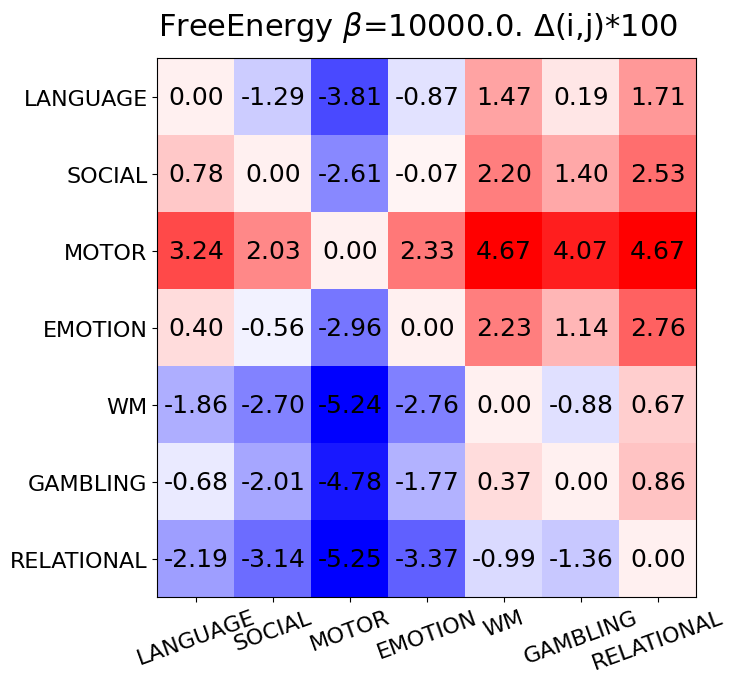

In [22]:
fig, ax2 = plt.subplots( figsize= (7,7))
asymmetry_matrix = np.zeros((7,7))
temp1 = np.zeros(n_cluster)
temp2 = np.zeros(n_cluster)
labels, values = zip(*sorted_medie_logprob)

soggetti_eseguiti = -1
for indice in indici_soggetti:
        soggetti_eseguiti += 1
        counter_rows = -1
        for a in labels:
                nome_task = a
                counter_rows += 1
                temp1_df = df[(df['subj'] == indice) & (df['task'] ==nome_task)]
                temp1_values = temp1_df.iloc[:, 2:].values
                inner_list1 = temp1_values[0]
                temp1 = np.array(inner_list1)
                counter_cols = -1       
                for b in labels:
                        counter_cols += 1
                        if(counter_rows == counter_cols):
                              asymmetry_matrix[counter_rows, counter_cols] = 0
                        else:
                                temp2_df = df[(df['subj'] == indice) & (df['task'] == b)]
                                temp2_values = temp2_df.iloc[:, 2:].values
                                inner_list2 = temp2_values[0]
                                temp2 = np.array(inner_list2)
                                # Calcolo i costi
                                G1, costo1 = instance.solve(temp1,temp2, log_transition_probability, epsilon_start, epsilon_stop)
                                G2, costo2 = instance.solve(temp2,temp1, log_transition_probability, epsilon_start, epsilon_stop)
                                asymmetry_matrix[counter_rows][counter_cols] += (costo1 - costo2)/costo1

asymmetry_matrix = asymmetry_matrix/n_soggetti
asymmetry_matrix = asymmetry_matrix*100
im2=ax2.imshow(asymmetry_matrix, cmap='bwr')
ax2.set_xticks(xpositions)
ax2.set_xticklabels(labels, fontsize = 16, rotation = 20)
ax2.set_yticks(xpositions)
ax2.set_yticklabels(labels, fontsize = 16)
#Display the values within each cell
for i in range(asymmetry_matrix.shape[0]):
    for j in range(asymmetry_matrix.shape[1]):
        text = ax2.text(j, i, f'{asymmetry_matrix[i, j]:.2f}', ha='center', va='center', color='black', fontsize=18)

###################################################################################################################################       
plt.suptitle(rf"FreeEnergy $\beta$={beta_stop}. $\Delta$(i,j)*100", y=0.95, fontsize= 22)

plt.savefig(f"fMRIconc_asimmetria_beta={beta_stop}.eps")
plt.savefig(f"fMRIconc_asimmetria_beta={beta_stop}.pdf")

# Plot delle occorrenze dei cluster in ciascuna task

struttura del file di imput: subj,task,0,1,2,3,4,5,6,7

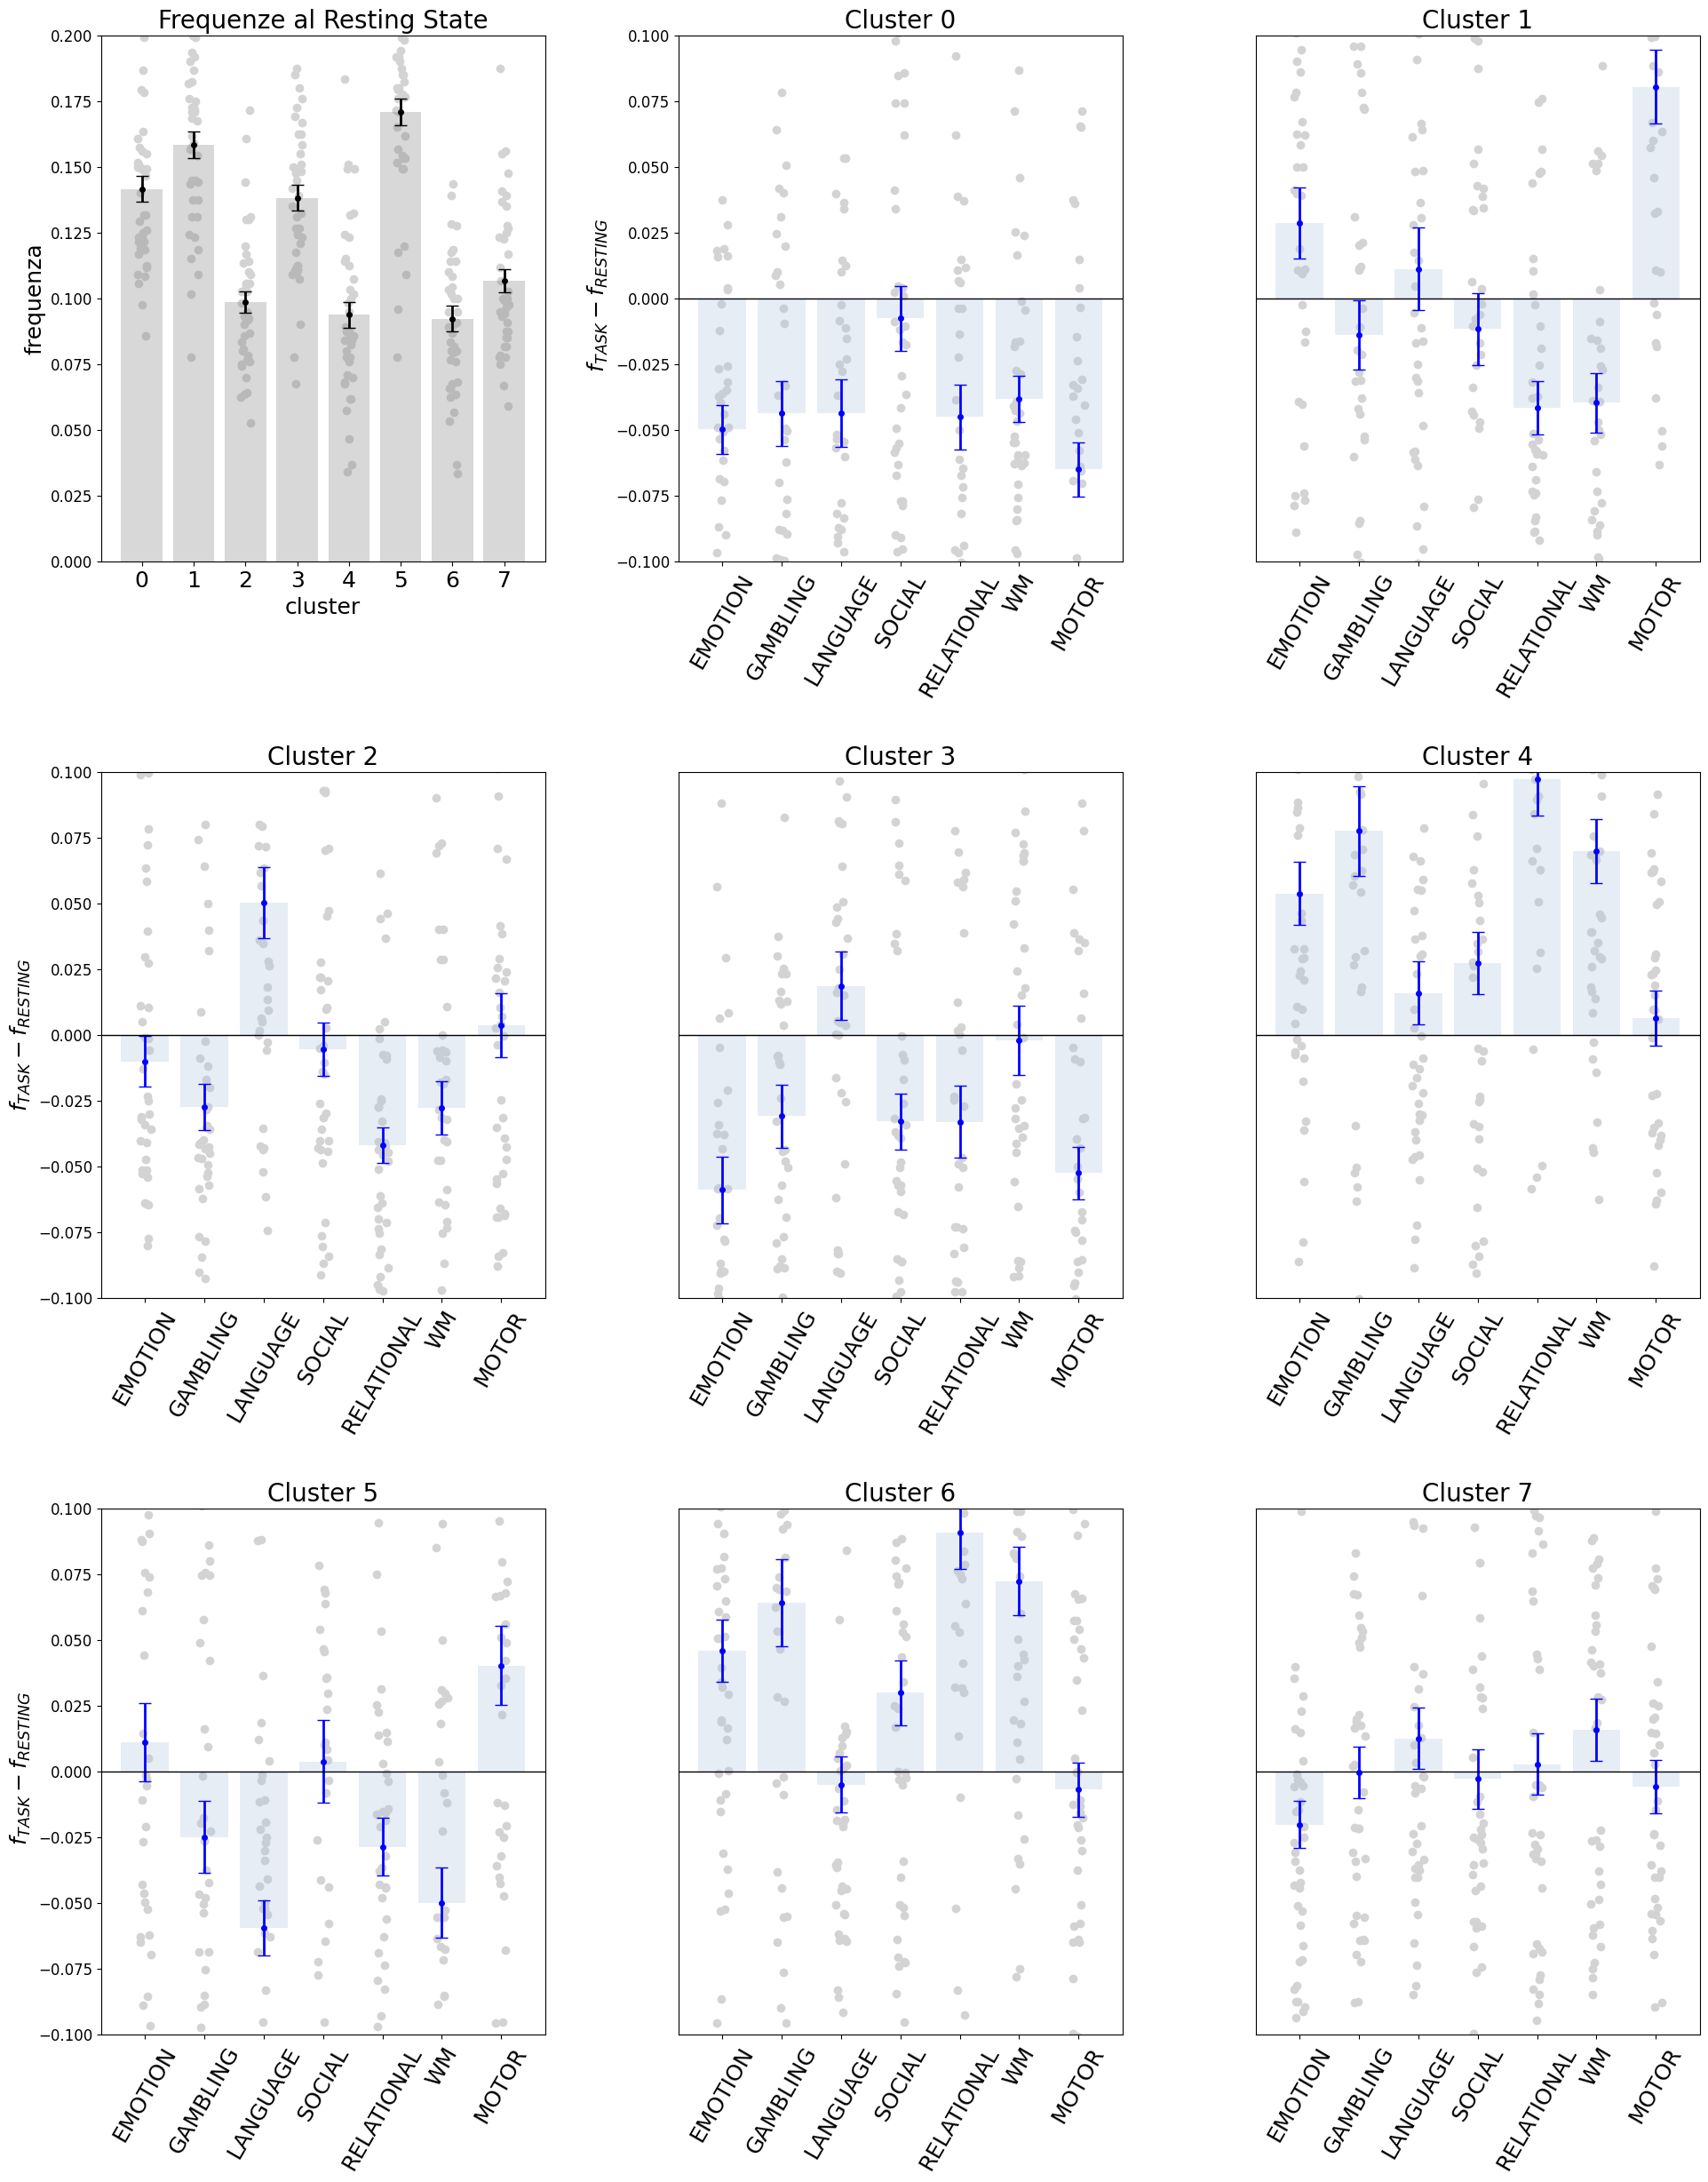

In [40]:
file_path = 'clusters_occurrence_k_8.csv'
df = pd.read_csv(file_path)
df.fillna(0, inplace=True)
nomi_cluster = [0,1,2,3,4,5,6,7]
nomi_task = ['EMOTION', 'GAMBLING', 'LANGUAGE', 'SOCIAL', 'RELATIONAL', 'WM', 'MOTOR']
fig = plt.figure(figsize=(20,25))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
gs=fig.add_gridspec(3,3, hspace=0.4, wspace=0.3)
########## posizione [0,0] REST1 ##############################
ax = fig.add_subplot(gs[0,0])
medie = []
error = []
counter = -1
for c in nomi_cluster:
    counter += 1
    prova_df = df[(df['task']=='REST1')]
    prova = prova_df[f'{c}'].values
    media = prova.mean(); medie += [media]
    errore_media = prova.std()/np.sqrt(prova.size); error += [errore_media]
    ax.scatter(np.random.uniform(counter-0.1, counter+0.1, prova.size), prova , color='lightgrey')
ax.errorbar(nomi_cluster, medie, yerr=error, marker='o', markersize=4, color='black', capsize=5, elinewidth=2, linestyle='None')
ax.bar(nomi_cluster, medie, color= 'gray', alpha= 0.3)
ax.set_xticks(range(len(nomi_cluster)))
ax.set_xticklabels(nomi_cluster, fontsize=18)
ax.set_ylim(0, 0.20)
ax.tick_params(axis='y', labelsize=12)
ax.set_title("Frequenze al Resting State", fontsize = 20)
ax.set_xlabel('cluster', fontsize=18)
ax.set_ylabel('frequenza', fontsize=18)
####### riga 0 : cluster 0,1 ###############
col_counter = -1
for c in nomi_cluster[:2]:
    col_counter += 1
    ax = fig.add_subplot (gs [0, col_counter+1])
    df_copy = df[['subj', 'task', f'{c}']].copy()
    resting_temporaneo_df = df_copy[df_copy['task'] == 'REST1']
    resting_temporaneo_values = resting_temporaneo_df[f'{c}'].values
    counter = -1
    medie = []
    error = []
    for t in nomi_task:
            counter += 1
            task_temp_df = df_copy[df_copy['task'] == t]
            values = task_temp_df[f'{c}'].values - resting_temporaneo_values
            media = values.mean(); medie += [media]
            errore_media = values.std()/np.sqrt(values.size); error += [errore_media]
            ax.scatter(np.random.uniform(counter-0.1, counter+0.1, values.size), values , color='lightgrey')
    ax.errorbar(nomi_task, medie, yerr=error, marker='o', markersize=4, color='blue', capsize=5, elinewidth=2, linestyle='None')
    ax.bar(nomi_task, medie, color= 'lightsteelblue', alpha= 0.3)
    ax.set_xticks(range(len(nomi_task)))
    ax.set_xticklabels(nomi_task, fontsize = 18, rotation = 60)
    ax.set_ylabel(' $f_{TASK}-f_{RESTING}$', fontsize = 18)
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_ylim(-0.1, +0.1)
    ax.set_title(f"Cluster {c}", fontsize = 20)
    ax.tick_params(axis='y', labelsize=12)
    if(col_counter!= 0):
        ax.set_yticks([])
        ax.set_ylabel('')
####### riga 2 : cluster 2,3,4 ###############
col_counter = -1
for c in nomi_cluster[2:5]:
    col_counter += 1
    ax = fig.add_subplot (gs [1, col_counter])
    df_copy = df[['subj', 'task', f'{c}']].copy()
    resting_temporaneo_df = df_copy[df_copy['task'] == 'REST1']
    resting_temporaneo_values = resting_temporaneo_df[f'{c}'].values
    counter = -1
    medie = []
    error = []
    for t in nomi_task:
            counter += 1
            task_temp_df = df_copy[df_copy['task'] == t]
            values = task_temp_df[f'{c}'].values - resting_temporaneo_values
            media = values.mean(); medie += [media]
            errore_media = values.std()/np.sqrt(values.size); error += [errore_media]
            ax.scatter(np.random.uniform(counter-0.1, counter+0.1, values.size), values , color='lightgrey')
    ax.errorbar(nomi_task, medie, yerr=error, marker='o', markersize=4, color='blue', capsize=5, elinewidth=2, linestyle='None')
    ax.bar(nomi_task, medie, color= 'lightsteelblue', alpha= 0.3)
    ax.set_xticks(range(len(nomi_task)))
    ax.set_xticklabels(nomi_task, fontsize = 18, rotation = 60)
    ax.set_ylabel('$f_{TASK}-f_{RESTING}$', fontsize = 18)
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_ylim(-0.1, +0.1)
    ax.set_title(f"Cluster {c}", fontsize = 20)
    ax.tick_params(axis='y', labelsize=12)
    if(col_counter!= 0):
        ax.set_yticks([])
        ax.set_ylabel('')
####### riga 2 : cluster 5,6,7 ###############
col_counter = -1
for c in nomi_cluster[5:8]:
    col_counter += 1
    ax = fig.add_subplot (gs [2, col_counter])
    df_copy = df[['subj', 'task', f'{c}']].copy()
    resting_temporaneo_df = df_copy[df_copy['task'] == 'REST1']
    resting_temporaneo_values = resting_temporaneo_df[f'{c}'].values
    counter = -1
    medie = []
    error = []
    for t in nomi_task:
            counter += 1
            task_temp_df = df_copy[df_copy['task'] == t]
            values = task_temp_df[f'{c}'].values - resting_temporaneo_values
            media = values.mean(); medie += [media]
            errore_media = values.std()/np.sqrt(values.size); error += [errore_media]
            ax.scatter(np.random.uniform(counter-0.1, counter+0.1, values.size), values , color='lightgrey')
    ax.errorbar(nomi_task, medie, yerr=error, marker='o', markersize=4, color='blue', capsize=5, elinewidth=2, linestyle='None')
    ax.bar(nomi_task, medie, color= 'lightsteelblue', alpha= 0.3)
    ax.set_xticks(range(len(nomi_task)))
    ax.set_xticklabels(nomi_task, fontsize = 18, rotation = 60)
    ax.set_ylabel(r' $f_{TASK}-f_{RESTING}$', fontsize = 18)
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_ylim(-0.1, +0.1)
    ax.set_title(f"Cluster {c}", fontsize = 20)
    ax.tick_params(axis='y', labelsize=12)
    if(col_counter!= 0):
        ax.set_yticks([])
        ax.set_ylabel('')

#plt.suptitle(r"Occorrenze dei cluster nelle varie task, rispetto alle occorrenze al resting.", fontsize = 20,  y=1)
plt.savefig(f"fMRIconc_cluster_occorrenze.pdf")